# ADS - Data Scientist Take Home Challenge

#### **About Dataset**
##### **Description**
This is a countrywide dataset of road construction and closure events, which covers 49 states of the US. Construction events in this dataset could be any roadwork, ranging from fixing pavements to substantial projects that could take months to finish. The data is collected from Jan 2016 to Dec 2021, using multiple APIs that provide streaming traffic incident (or event) data. These APIs broadcast traffic data captured by a variety of entities, such as the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road-networks. Currently, there are about 6.2 million construction and closure records in this dataset.

##### **Acknowledgements**
- _Karimi Monsefi, Amin, Sobhan Moosavi, and Rajiv Ramnath. <u>“Will there be a construction? Predicting road constructions based on heterogeneous spatiotemporal data.”</u>, In Proceedings of the 30th ACM SIGSPATIAL 2022._

## Approach to Construction Impact Analysis
#### Autonomous Vehicle Deployment Strategy & Risk Assessment

- **Goal 1:** A comprehensive analysis of US road construction for AV deployment strategy
- **Goal 2:** A risk assessment comparison among specific routes in Bay Area CA 
- **Goal 3:** A predictive model development to estimate construction duration proactively

#### Goal 1: __A comprehensive analysis of US road construction for AV deployment strategy__

##### Targets:
- Ingest Data
    - Get data from Kaggle
    - Prepare parquet data
- Intial Explanatory Data Analytics
    - Stats
    - Maps showing constructions
- Feature Extractions
- Top construction activity by cities
- Time series trends by cities
- Compare among cities

#### Goal 2: __A risk assessment comparison among specific routes in Bay Area CA__

##### Targets:
- Matching/tagging construction activity using spatial query
- Mapping the construction for interactive data explore by year, severity and other KPIs
- Generating a risk score
- Idea for extra miles to go

#### Goal 3: __A predictive model development to estimate construction duration proactively__

##### Targets:
- Explore corelation between duration and other variables
- Predict simple models
- Any advance models
- Idea for extra miles to go

#### Data Processing Approach
- Ingest Kaggle data using API
- Store data in parquet format
- Get the additional data
    - Census population, employment
    - National Road network for frieghts: to get the road density of cities - generating city size to normalize
- Extract features from additional files

### Data Ingest

#### Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime, timedelta
import datetime as dt
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import kagglehub
from kagglehub import KaggleDatasetAdapter

#kagglehub.login()
from datetime import datetime, timedelta
from os.path import join as join

from ipyleaflet import Map, GeoData, LayersControl, basemaps
import matplotlib.colors as mcolors
import requests
import io
from ipywidgets import VBox

##### Input Output directories

In [2]:
# # Kaggle dataset description:
# # https://www.kaggle.com/datasets/sobhanmoosavi/us-road-construction-and-closures
# repo = "sobhanmoosavi/us-road-construction-and-closures"
# file_name = "US_Constructions_Dec21"

# # Route file details
# rt_file_dir = r"C:\Users\smomt\OneDrive\Documents\work\Interview\Aurora\Take Home"
# rt_file_name = "sf_paths (2).csv"
# out_rt_file_name = "sf_paths.parquet"

# output_dir = r"C:\Users\smomt\OneDrive\Documents\work\Interview\Aurora\Take Home\data"

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)


##### Kaggle data load

In [3]:
# dataset_path = kagglehub.dataset_download(repo, force_download=True)
# file_path = f"{dataset_path}/{file_name}.csv"
# df = pd.read_csv(file_path, low_memory=False)

### Initial Explanatory Data Analytics (EDA)

In [ ]:
#par_dir = r"C:\Users\smomt\OneDrive\Documents\work\Interview\Aurora\Take Home"
# Google Drive direct download URL
route_url = "https://drive.google.com/uc?export=download&id=1qpx8iktc2wfwCE_2sMv5ODaB3PV4z7HH"

# Fetch file
response = requests.get(route_url)
response.raise_for_status()  # ensure we catch a failed download

#### Route Data

In [ ]:
#df_routes = gpd.read_parquet(join(par_dir, "sf_paths.parquet"))
df_routes = gpd.read_parquet(io.BytesIO(response.content))
display(df_routes)

,path_name,distance_mi,geometry
0,SF -> Berkley,13.58,"LINESTRING (-122.41928 37.77492, -122.4192 37...."
1,SF -> San Rafael,18.66,"LINESTRING (-122.41928 37.77492, -122.41872 37..."
2,SF -> San Mateo,19.30,"LINESTRING (-122.41928 37.77492, -122.41872 37..."
3,SF -> San Leandro,21.21,"LINESTRING (-122.41928 37.77492, -122.41872 37..."
4,SF -> Pacifica,15.37,"LINESTRING (-122.41928 37.77492, -122.41872 37..."


In [6]:
df_routes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# path_names = df_routes['path_name'].unique()
# color_map = {}

# for i, p in enumerate(path_names):
#     color_map[p] = colors[i]
# #color_map = {name: colors[i % len(colors)] for i, name in enumerate(path_names)}
# color_map

In [8]:
# Create map with a base map
center = [37.78, -122.42]   #SFO
#m = Map(center=center, zoom=10, basemap=basemaps.OpenStreetMap.Mapnik)
m = Map(center=center, zoom=11, basemap=basemaps.CartoDB.DarkMatter, scroll_wheel_zoom=True, layout={'height': '650px', 'width': '100%'})

# Get tableau color for routes
path_names = df_routes['path_name'].unique()
colors = list(mcolors.TABLEAU_COLORS.values())
color_map = {}

for i, pn in enumerate(path_names):
    color_map[pn] = colors[i]
    
# Add each routes to map
for pn in path_names:
    geo_data = GeoData(
        geo_dataframe=df_routes[df_routes['path_name'] == pn],
        style = {'color': color_map[pn], 'weight': 5},
        name = pn
    )
    m.add_layer(geo_data)

m.add_control(LayersControl())

# Display the map
m

Map(center=[37.78, -122.42], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [9]:
# Get the bounding box covers all the routes
min_x, min_y, max_x, max_y = df_routes.total_bounds
#(min_x, min_y, max_x, max_y)
print(f"Bounding box for all routes: (min lat: {min_y}, min long: {min_x}, max lat: {max_y}, max long: {max_x})")

Bounding box for all routes: (min lat: 37.56168, min long: -122.5311, max lat: 37.97343, max long: -122.1568)


#### Constraction Data

In [ ]:
cons_url = "https://drive.google.com/file/d/1wZIQrxNWl6vkkkK2PGp9r9O0beKIMhYI/view?usp=drive_link"

# Fetch file
response = requests.get(cons_url)
response.raise_for_status()  # ensure we catch a failed download

In [ ]:
#df_cons = pd.read_parquet(join(par_dir, "US_Constructions_Dec21.parquet"))
df_cons = pd.read_parquet(io.BytesIO(response.content))
display(df_cons.head())

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,C-1,4,2019-04-05 16:00:00.000000000,2020-09-29 11:53:57.000000000,32.838360,-93.152378,32.850740,-93.164388,1.103497,Construction on LA-534 WB near EDMONDS LOOP Ro...,...,False,False,False,False,False,False,Day,Day,Day,Day
1,C-2,2,2021-11-12 07:59:00.000000000,2021-11-12 08:22:30.000000000,30.221331,-92.008625,30.216642,-92.003809,0.433173,Slow traffic on US-90 E from US-167/Louisiana ...,...,False,False,False,False,False,False,Day,Day,Day,Day
2,C-3,2,2021-10-12 07:17:30.000000000,2021-10-12 09:18:55.000000000,39.653153,-104.910224,39.653120,-104.913838,0.192266,Slow traffic on CO-30 from S Tamarac Dr (E Ham...,...,False,True,False,False,False,False,Day,Day,Day,Day
3,C-4,4,2021-02-10 02:46:10.000000000,2021-02-17 23:59:00.000000000,33.961506,-118.029339,33.961919,-118.029082,0.032112,Closed road from Whittier to College Ave due t...,...,False,False,False,False,False,False,Night,Night,Night,Night
4,C-5,2,2020-09-24 15:58:00.000000000,2020-09-25 21:04:54.000000000,40.008734,-79.599696,40.022822,-79.595703,0.996057,Construction on US-119 NB near SAMPSON ST Allo...,...,False,False,False,False,False,False,Day,Day,Day,Day


In [11]:
df_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170627 entries, 0 to 6170626
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

In [12]:
df_cons["ID"] = df_cons["ID"].astype(str)
df_cons["ID"].nunique()

6170627

In [13]:
round(df_cons["Severity"].value_counts(normalize=True)*100,1)

Severity
2    83.0
4     9.7
3     6.7
1     0.7
Name: proportion, dtype: float64

In [14]:
round(df_cons["Side"].value_counts(normalize=True)*100,1)

Side
R    74.2
L    25.8
N     0.0
Name: proportion, dtype: float64

In [15]:
df_cons["Side"].value_counts()

Side
R    4577040
L    1593585
N          2
Name: count, dtype: int64

In [16]:
round(df_cons[["Sunrise_Sunset"]].value_counts(normalize=True)*100,1)

Sunrise_Sunset
Day               64.7
Night             35.3
Name: proportion, dtype: float64

In [17]:
df_cons.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,6.170627e+06,6.170627e+06,6.170627e+06,5.536579e+06,5.536579e+06,6.170627e+06,3.495798e+06,6.055233e+06,5.394061e+06,6.048067e+06,6.066309e+06,6.028381e+06,5.830350e+06,5.248183e+06
mean,2.253898e+00,3.729715e+01,-9.144676e+01,3.717219e+01,-9.134230e+01,1.259217e+00,5.941666e+03,6.318595e+01,6.199467e+01,6.334873e+01,2.916802e+01,9.426172e+00,7.304058e+00,3.773323e-03
std,6.296634e-01,5.515846e+00,1.611645e+01,5.586545e+00,1.592293e+01,3.977114e+00,1.291896e+04,1.795553e+01,2.023514e+01,2.281208e+01,1.471270e+00,1.412101e+01,5.422413e+00,8.961252e-02
min,1.000000e+00,2.088731e+01,-1.579783e+02,2.088772e+01,-1.579768e+02,0.000000e+00,1.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.349486e+01,-1.049825e+02,3.348016e+01,-1.049599e+02,1.324791e-01,6.690000e+02,5.100000e+01,5.000000e+01,4.700000e+01,2.898000e+01,1.000000e+01,3.500000e+00,0.000000e+00
50%,2.000000e+00,3.925449e+01,-8.571116e+01,3.919636e+01,-8.566375e+01,3.249112e-01,2.408000e+03,6.600000e+01,6.600000e+01,6.500000e+01,2.966000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.105826e+01,-7.886149e+01,4.097113e+01,-7.915132e+01,1.031883e+00,6.799000e+03,7.700000e+01,7.700000e+01,8.200000e+01,2.999000e+01,1.000000e+01,1.000000e+01,0.000000e+00
max,4.000000e+00,4.900083e+01,-6.706635e+01,4.900701e+01,-6.706634e+01,6.877400e+02,9.610510e+05,1.960000e+02,1.960000e+02,1.000000e+02,5.855000e+01,3.400700e+04,9.830000e+02,2.400000e+01


In [18]:
missing_df = pd.DataFrame(df_cons.isna().sum()).reset_index()
missing_df.columns = ['variable', 'missing_count']
missing_df['missing_percentage'] = (missing_df['missing_count'] / len(df_cons)) * 100
missing_df = missing_df[missing_df['missing_count'] > 0]
display(missing_df.sort_values(by="missing_percentage", ascending=False))

,variable,missing_count,missing_percentage
10,Number,2674829,43.347767
28,Precipitation(in),922444,14.948951
22,Wind_Chill(F),776566,12.584880
6,End_Lat,634048,10.275261
7,End_Lng,634048,10.275261
27,Wind_Speed(mph),340277,5.514464
26,Wind_Direction,162549,2.634238
25,Visibility(mi),142246,2.305211
29,Weather_Condition,138203,2.239691
23,Humidity(%),122560,1.986184


#### __most of the missing variables will not be used in analytics, gives a great clean data!!! End Lat/Long might be needed to match, assuming the missing would not be a concern for this analytics__

In [19]:
# Filter to keep constructions only within the bounding box of route shapefile
df_cons_sf = df_cons[
    ((df_cons['Start_Lng'] >= min_x) & (df_cons['Start_Lng'] <= max_x) &
     (df_cons['Start_Lat'] >= min_y) & (df_cons['Start_Lat'] <= max_y)) |
    ((df_cons['End_Lng'] >= min_x) & (df_cons['End_Lng'] <= max_x) &
     (df_cons['End_Lat'] >= min_y) & (df_cons['End_Lat'] <= max_y))
]
len(df_cons_sf)

32600

In [20]:
missing_df_sf = pd.DataFrame(df_cons_sf.isna().sum()).reset_index()
missing_df_sf.columns = ['variable', 'missing_count']
missing_df_sf['missing_percentage'] = (missing_df_sf['missing_count'] / len(df_cons_sf)) * 100
missing_df_sf = missing_df_sf[missing_df_sf['missing_count'] > 0]
display(missing_df_sf.sort_values(by='missing_percentage', ascending=False))

,variable,missing_count,missing_percentage
10,Number,19486,59.773006
6,End_Lat,11057,33.917178
7,End_Lng,11057,33.917178
22,Wind_Chill(F),6658,20.423313
28,Precipitation(in),6570,20.153374
27,Wind_Speed(mph),1487,4.561350
29,Weather_Condition,531,1.628834
26,Wind_Direction,489,1.500000
24,Pressure(in),454,1.392638
25,Visibility(mi),453,1.389571


#### __End lat long is missing for about one third of the Bay area construction - assuming the missing data is outside of the Bay area for simplicity of estimation for this analytics.__

In [21]:
df_cons_sf["Start_Time"] = pd.to_datetime(df_cons_sf["Start_Time"], errors='coerce')
df_cons_sf["End_Time"] = pd.to_datetime(df_cons_sf["End_Time"], errors='coerce')

df_cons_sf['year'] = df_cons_sf["Start_Time"].dt.year

print(f"No of construction in Bay area: {len(df_cons_sf)}")
df_cons_sf.groupby('year').size()

No of construction in Bay area: 32600


year
2016.0     298
2017.0     238
2018.0     926
2019.0    2306
2020.0    3239
2021.0    2519
dtype: int64

##### __About 32 thousand constructions with increasing constructions during Covid pendamic time__

#### Explore construction on Map

In [22]:
from ipyleaflet import Map, Heatmap, GeoData, LayersControl, basemaps

def get_heatmap(df, latcol, longcol):
    # Heatmap data
    data = df[[latcol, longcol]].dropna().values.tolist()

    # Base Map
    center = [df[latcol].mean(), df[longcol].mean()]
    heat_map = Map(center=center, zoom=11, basemap=basemaps.CartoDB.DarkMatter, scroll_wheel_zoom=True, layout={'height': '650px'})

    # Heatmap
    heatmap = Heatmap(locations=data, radius=12, blur=10, min_opacity=0.4, name='Heatmap')
    heat_map.add_layer(heatmap)

    # Add routes
    routes = GeoData(
        geo_dataframe=df_routes,
        style={'color': 'white', 'weight': 3, 'opacity': 0.7},
        name='Routes'
    )
    heat_map.add_layer(routes)

    # Add layer control
    heat_map.add_control(LayersControl())

    return heat_map

In [23]:
get_heatmap(df = df_cons_sf, latcol = 'Start_Lat', longcol = 'Start_Lng')

Map(center=[np.float64(37.770091778834356), np.float64(-122.36850635346624)], controls=(ZoomControl(options=['…

#### Shows a clear hotspot around the selected routes SF - Pacific visually seems to have lower constructions

#### Feature Extractions

##### Duration

In [24]:
df_cons['start_date'] = pd.to_datetime(df_cons['Start_Time'], format='mixed', errors='coerce')
df_cons['end_date'] = pd.to_datetime(df_cons['End_Time'], format='mixed', errors='coerce')

df_cons["year"] = df_cons['start_date'].dt.year

#Duration
df_cons['duration'] = (df_cons['end_date'] - df_cons['start_date']).dt.total_seconds()/60/60

In [25]:
df_cons['CityST'] = df_cons['City'].fillna('') + " - " + df_cons['State'].fillna('')
#df_cons['CityST'].unique()

#### 1. Over the past 5 years which city has had the most hours of construction?

##### Top 5 Cities for 5 years

In [26]:
# Durations by city
city_construction_duration = df_cons.groupby('CityST')['duration'].sum().reset_index()

# Get max duration
#max_duration = city_construction_duration["duration"].max()
#top_city_duration = city_construction_duration[city_construction_duration["duration"] == max_duration]
city_construction_duration = city_construction_duration.sort_values(by='duration', ascending=False)
top_city_duration = city_construction_duration.head(5).copy()
top_city_duration.reset_index(drop=True, inplace=True)
#top_city_duration['duration'] = top_city_duration['duration'].apply(lambda x: f"{x:,}")
top_city_duration['duration'] = top_city_duration['duration'].astype(float).map(lambda x: f"{x:,.1f}")
display(top_city_duration)

,CityST,duration
0,Phoenix - AZ,"125,651,161.2"
1,Miami - FL,"65,121,285.7"
2,New York - NY,"44,081,413.6"
3,Chicago - IL,"31,014,692.8"
4,Brooklyn - NY,"29,904,198.1"


##### Top City for 5 years construction activity

In [27]:
topmostcity = top_city_duration.iloc[0]
print(f"Top city with most construction duration over 5 year is  {topmostcity['CityST']} with a total duration of {topmostcity['duration']} combined hours.")

Top city with most construction duration over 5 year is  Phoenix - AZ with a total duration of 125,651,161.2 combined hours.


#### So, over the past 5 years **_Phoenix city, AZ_** has had the most hours of construction.
##### with a total duration of over 125.6 million combined hours of constructions.

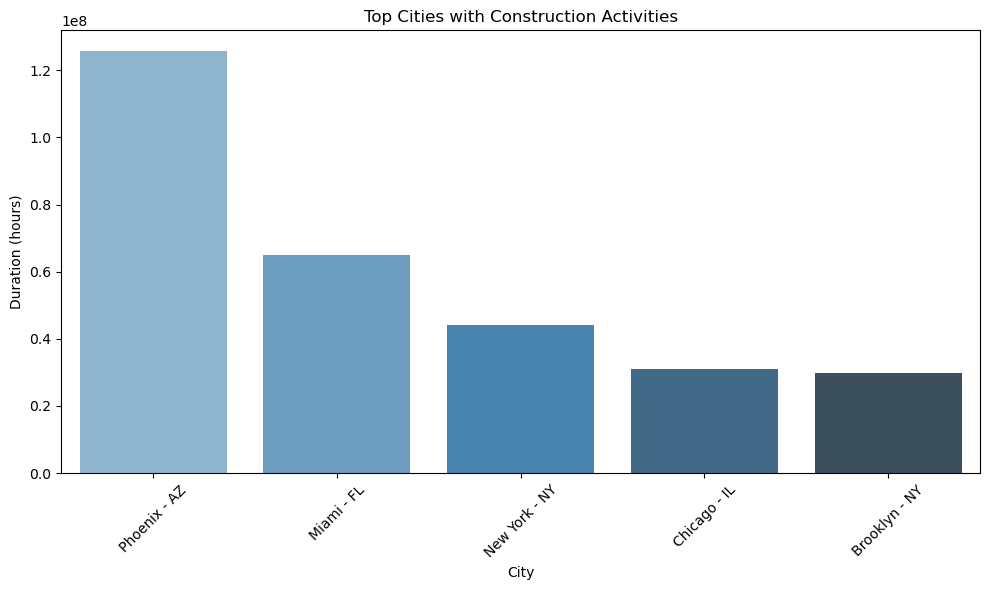

In [28]:
top_city_duration["duration"] = top_city_duration["duration"].str.replace(",","").astype(float)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_city_duration, x='CityST', y='duration', palette='Blues_d')
plt.title('Top Cities with Construction Activities')
plt.xlabel('City')
plt.ylabel('Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Top City for by year

In [29]:
df_cons['year'] = df_cons['start_date'].dt.year
yearly_construction_hr = df_cons.groupby(['year', 'CityST'])['duration'].sum().reset_index()

yearly_construction_hr["yearly_rank"] = yearly_construction_hr.groupby('year')['duration'].rank(method='first', ascending=False)

# Filter to get the top city for each year
listofcities = list(yearly_construction_hr[yearly_construction_hr["yearly_rank"] <= 1].sort_values(by=['year', 'yearly_rank'], ascending=[True, True])["CityST"].unique())

yearly_construction_pivot = yearly_construction_hr[yearly_construction_hr['CityST'].isin(listofcities)].pivot(index='CityST', columns='year', values='duration').fillna(0)
#display(yearly_construction_pivot)
yearly_construction_pivot = yearly_construction_pivot.astype(int)

# Table highlights highest in column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: blue' if v else '' for v in is_max]

display(yearly_construction_pivot.style.apply(highlight_max, axis=0))

year,2016,2017,2018,2019,2020,2021
CityST,,,,,,
Cle Elum - WA,19642,40110,30130,17790324,53855,385745
Middletown - DE,10370644,27584,36755,1056808,54157,542697
Phoenix - AZ,515647,3142376,950877,6331334,11896578,102814347
Winnfield - LA,0,0,9788814,1946,78821,15632
York - PA,14185,10315584,2577912,6223622,814105,1311025


##### Though Phoenix, AZ topped on construction for last two years (2020 & 2021). The city with most combined construction hours changed every year for previous four years.
##### _**Phoenix, AZ**'s COVID time construction work really get them top of the chart._

##### While the total hour will provide hurdle in operation to be closed through out the year, the exposer to the hurdle while driving/operating would comes from the combined matric of hour impacting the route and the length of the road to drive in construction zone. Therefore Hour-mile is important here just like the VMT or Ton-millage meassures in typical transportation matrics. Therefore we will explore the hour-mile as well.

##### Top City for 5 years by hour - length

In [30]:
# hour-mile by city
df_cons['hr-mi'] = df_cons['duration'] * df_cons["Distance(mi)"]

city_construction_hr_mi = df_cons.groupby('CityST')['hr-mi'].sum().reset_index()

city_construction_hr_mi = city_construction_hr_mi.sort_values(by='hr-mi', ascending=False)

top_city_hr_mi = city_construction_hr_mi.head(10).copy()
top_city_hr_mi.reset_index(drop=True, inplace=True)
display(top_city_hr_mi)

,CityST,hr-mi
0,Cle Elum - WA,6.560310e+07
1,Miami - FL,4.316923e+07
2,Lemmon - SD,3.598990e+07
3,Orlando - FL,3.186915e+07
4,North Bend - WA,3.161171e+07
5,Elgin - IL,2.903020e+07
6,Kissimmee - FL,2.845549e+07
7,Homestead - FL,2.605858e+07
8,Shadehill - SD,2.561736e+07
9,Phoenix - AZ,2.334852e+07


##### Phoenix, AZ has highest construction hours which poses a great risk in more days to hamper in operations, but in terms or driving through the construction zones the city does not poses highest threat to the autonomous trucks

##### Top City for 5 years in hour - length by year

In [31]:
##FIXME: create a function - reused
yearly_construction_hr_mi = df_cons.groupby(['year', 'CityST'])['hr-mi'].sum().reset_index()

yearly_construction_hr_mi["yearly_rank"] = yearly_construction_hr_mi.groupby('year')['hr-mi'].rank(method='first', ascending=False)

# Get the top City for each year
listofcities2 = list(yearly_construction_hr_mi[yearly_construction_hr_mi["yearly_rank"] <= 1].sort_values(by=['year', 'yearly_rank'], ascending=[True, True])["CityST"].unique())

yearly_construction_pivot_hr_mi = yearly_construction_hr_mi[yearly_construction_hr_mi['CityST'].isin(listofcities2)].pivot(index='CityST', columns='year', values='hr-mi').fillna(0)
#display(yearly_construction_pivot)

yearly_construction_pivot_hr_mi = yearly_construction_pivot_hr_mi.astype(int)

# highlight table
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: blue' if v else '' for v in is_max]

display(yearly_construction_pivot_hr_mi.style.apply(highlight_max, axis=0))

year,2016,2017,2018,2019,2020,2021
CityST,,,,,,
Cle Elum - WA,465,145900,68259,64094199,324344,969930
Elgin - IL,28097935,40350,3707,115808,171132,601260
Homestead - FL,21,1611,20781,5285213,20705101,45847
Phoenix - AZ,616165,1070636,339252,1654792,2011912,17655756
Tallahassee - FL,0,19494443,49080,186423,93347,743449
Winnfield - LA,0,0,18754707,198,61479,743


#### Phoenix, AZ has again a huge jump with the highest hour-mile
### Therefore, **Phoenix, AZ** has both highest hour (duration) and hour-mile (exposed to construction zone) in 2021!!

##### Top City for 5 years in hour - length by Severity

In [32]:
Severity_construction_hr_mi = df_cons.groupby(['Severity', 'CityST'])['hr-mi'].sum().reset_index()

Severity_construction_hr_mi["Severity_rank"] = Severity_construction_hr_mi.groupby('Severity')['hr-mi'].rank(method='first', ascending=False)

listofcities3 = list(Severity_construction_hr_mi[Severity_construction_hr_mi["Severity_rank"] <= 1].sort_values(by=['Severity', 'Severity_rank'], ascending=[True, True])["CityST"].unique())

Severity_construction_hr_mi = Severity_construction_hr_mi[Severity_construction_hr_mi['CityST'].isin(listofcities3)].pivot(index='CityST', columns='Severity', values='hr-mi').fillna(0)

Severity_construction_pivot_hr_mi = Severity_construction_hr_mi.astype(int)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: blue' if v else '' for v in is_max]

display(Severity_construction_pivot_hr_mi.style.apply(highlight_max, axis=0))

Severity,1,2,3,4
CityST,,,,
Bonham - TX,1330411,252805,0,2603
Cle Elum - WA,83,65174192,415865,12958
Elgin - IL,9943,1179624,27836922,3705
Waterloo - IA,3230,751332,115296,5916718


##### _However, in terms of different severity level Phoenix did not score highest!!_

#### 2. How has this changed over time? (please provide a chart)

Since the the leading city has changed over time, we would evaluate the changes over time is two ways - first we would explore the changes for the top most city combined 5 years construction activities.

In [33]:
import matplotlib.dates as mdates

df_cons['Start_Time'] = pd.to_datetime(df_cons['Start_Time'], format='mixed', errors='coerce')
df_cons['month_year'] = df_cons['Start_Time'].dt.to_period('M')

##### Change of city having highest hour of construction over 5 years - _**Phoenix, AZ**_ - Monthly changes

In [34]:
# construction for Phoenix
df_cons_phoenix = df_cons[df_cons["CityST"] == "Phoenix - AZ"].copy()
len(df_cons_phoenix)

251549

In [35]:
# Get Months
df_monthly_phoenix = df_cons_phoenix.groupby('month_year')['duration'].sum().reset_index()

df_monthly_phoenix['month_year_dt'] = df_monthly_phoenix['month_year'].dt.to_timestamp()
df_monthly_phoenix = df_monthly_phoenix.sort_values('month_year_dt')

display(df_monthly_phoenix)

,month_year,duration,month_year_dt
0,2016-06,1.001812e+04,2016-06-01
1,2016-07,1.091500e+03,2016-07-01
2,2016-08,2.013863e+04,2016-08-01
3,2016-09,6.955262e+03,2016-09-01
4,2016-10,4.362178e+05,2016-10-01
...,...,...,...
62,2021-08,5.066546e+06,2021-08-01
63,2021-09,3.270889e+06,2021-09-01
64,2021-10,1.958924e+06,2021-10-01
65,2021-11,9.779732e+05,2021-11-01


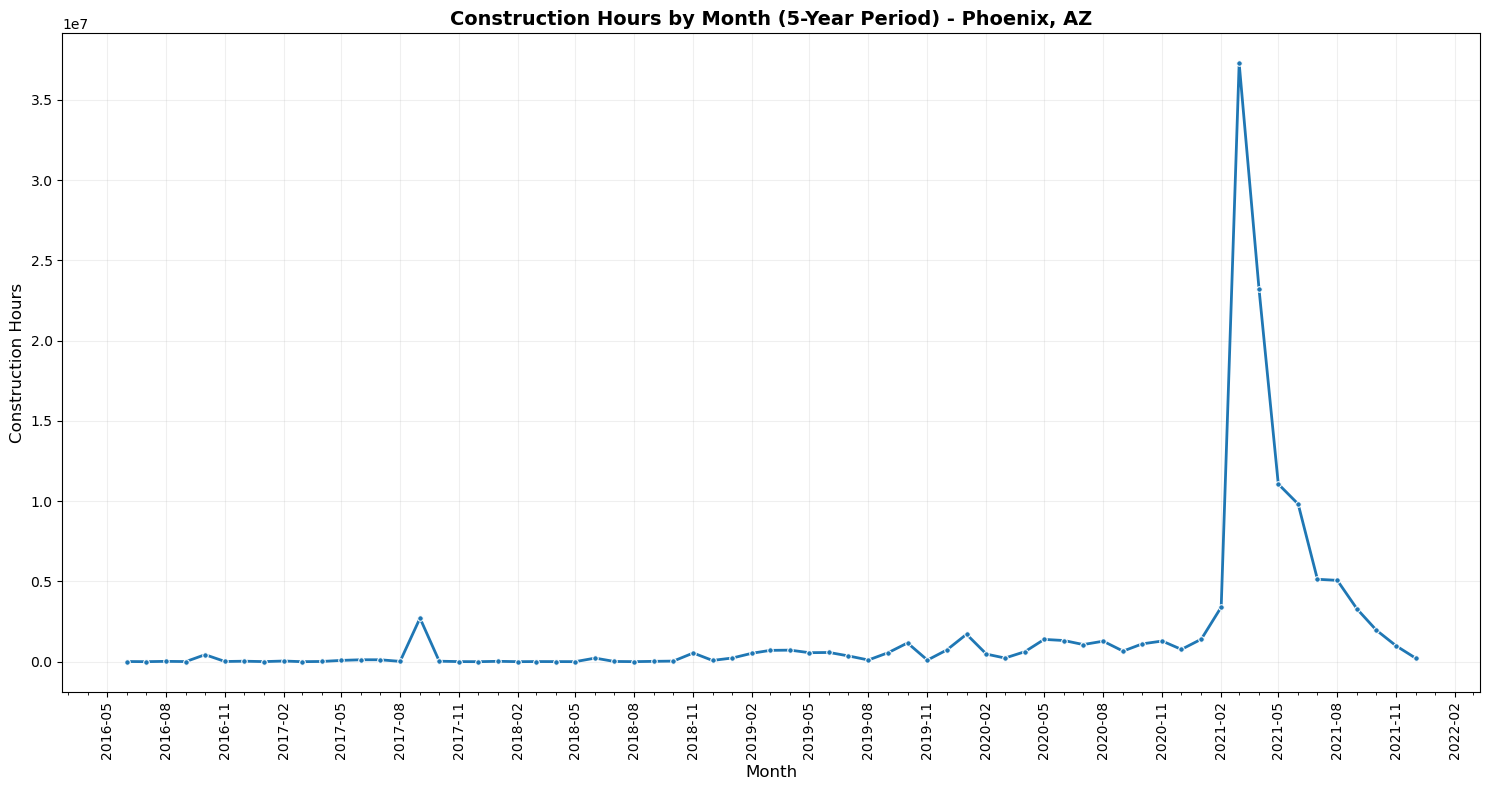

In [36]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_monthly_phoenix, x='month_year_dt', y='duration', linewidth=2, marker='o', markersize=4)

plt.title('Construction Hours by Month (5-Year Period) - Phoenix, AZ', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Construction Hours', fontsize=12)
plt.grid(True, alpha=0.2)

# Format x-axis for better monthly display
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


##### During the Month of **March 2021** to **June 2021** the Construction duration hiked significantly

##### Change of city having highest hour-mile of construction over 5 years - _**Cle Elum, WA**_ - Monthly changes

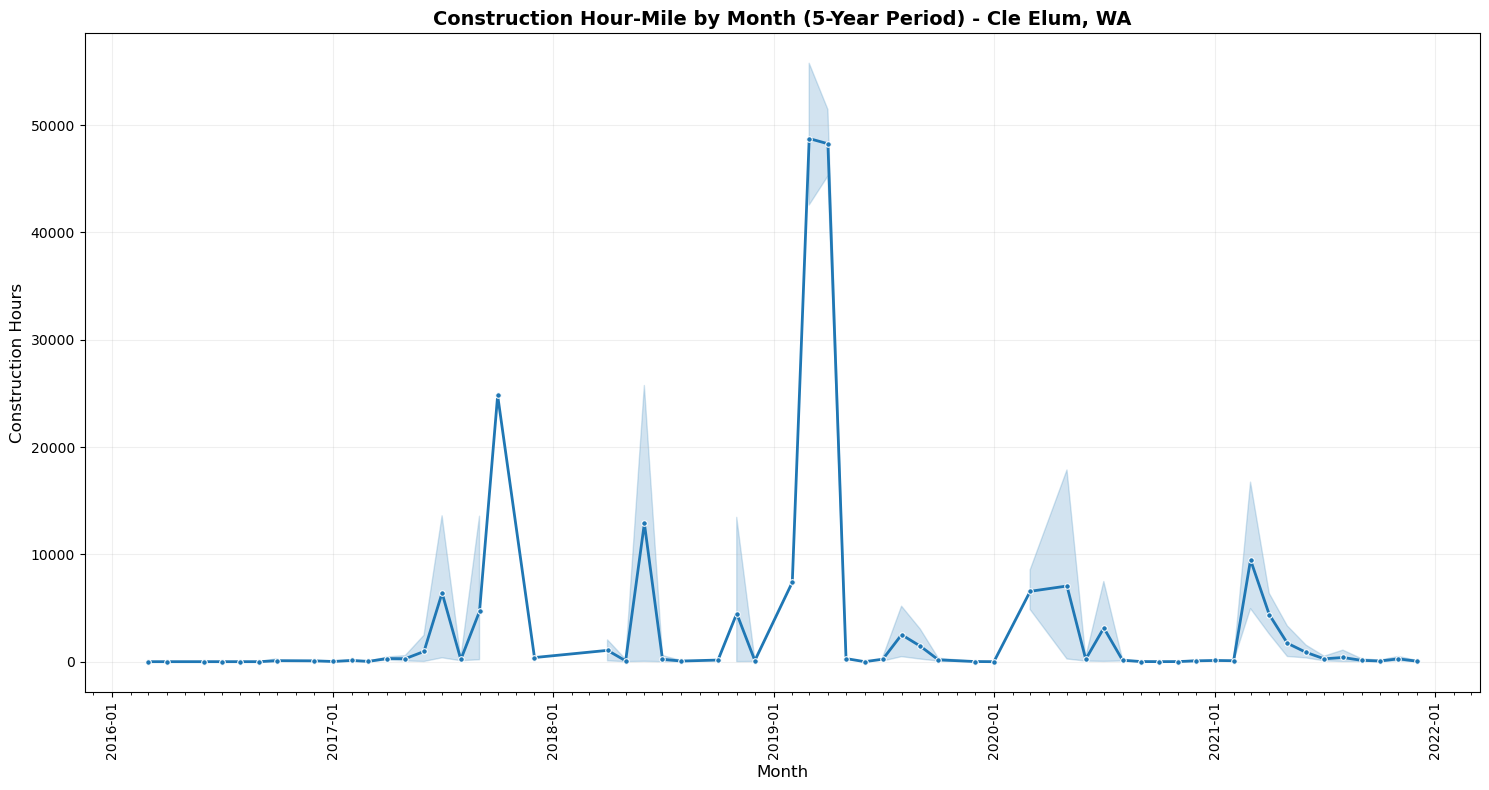

In [37]:
df_cons_CleElumWA = df_cons[df_cons["CityST"] == "Cle Elum - WA"].copy()
df_monthly_CleElumWA = df_cons_CleElumWA.groupby('month_year')['hr-mi'].sum().reset_index()

df_cons_CleElumWA['month_year_dt'] = df_cons_CleElumWA['month_year'].dt.to_timestamp()
df_cons_CleElumWA = df_cons_CleElumWA.sort_values('month_year_dt')

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_cons_CleElumWA, x='month_year_dt', y='hr-mi', linewidth=2, marker='o', markersize=4)

plt.title('Construction Hour-Mile by Month (5-Year Period) - Cle Elum, WA', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Construction Hours', fontsize=12)
plt.grid(True, alpha=0.2)
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

##### Typically showing Q2 with higher impact of construction for Cle Elum city WA. Where last two years has more activities during first half on the years.

##### Change of city having highest hour of construction in a given year over 5 years - Monthly changes

In [38]:
listofcities_6 = list(yearly_construction_hr[yearly_construction_hr['yearly_rank'] == 1]["CityST"].unique())
listofcities_6

['Middletown - DE',
 'York - PA',
 'Winnfield - LA',
 'Cle Elum - WA',
 'Phoenix - AZ']

In [39]:
df_cons_top_cities = df_cons[df_cons["CityST"].isin(listofcities_6)].copy()
df_monthly_top_cities = df_cons_top_cities.groupby(['month_year', "CityST"])['duration'].sum().reset_index()

df_monthly_top_cities['month_year_dt'] = df_monthly_top_cities['month_year'].dt.to_timestamp()
df_monthly_top_cities = df_monthly_top_cities.sort_values('month_year_dt')

display(df_monthly_top_cities)

,month_year,CityST,duration,month_year_dt
0,2016-03,Cle Elum - WA,13700.771111,2016-03-01
1,2016-04,Cle Elum - WA,2066.006667,2016-04-01
2,2016-04,Middletown - DE,88157.966667,2016-04-01
3,2016-04,York - PA,4343.966667,2016-04-01
4,2016-06,Cle Elum - WA,3204.140278,2016-06-01
...,...,...,...,...
268,2021-12,Phoenix - AZ,223201.695278,2021-12-01
269,2021-12,Winnfield - LA,0.341667,2021-12-01
266,2021-12,Cle Elum - WA,168.941389,2021-12-01
267,2021-12,Middletown - DE,96.133333,2021-12-01


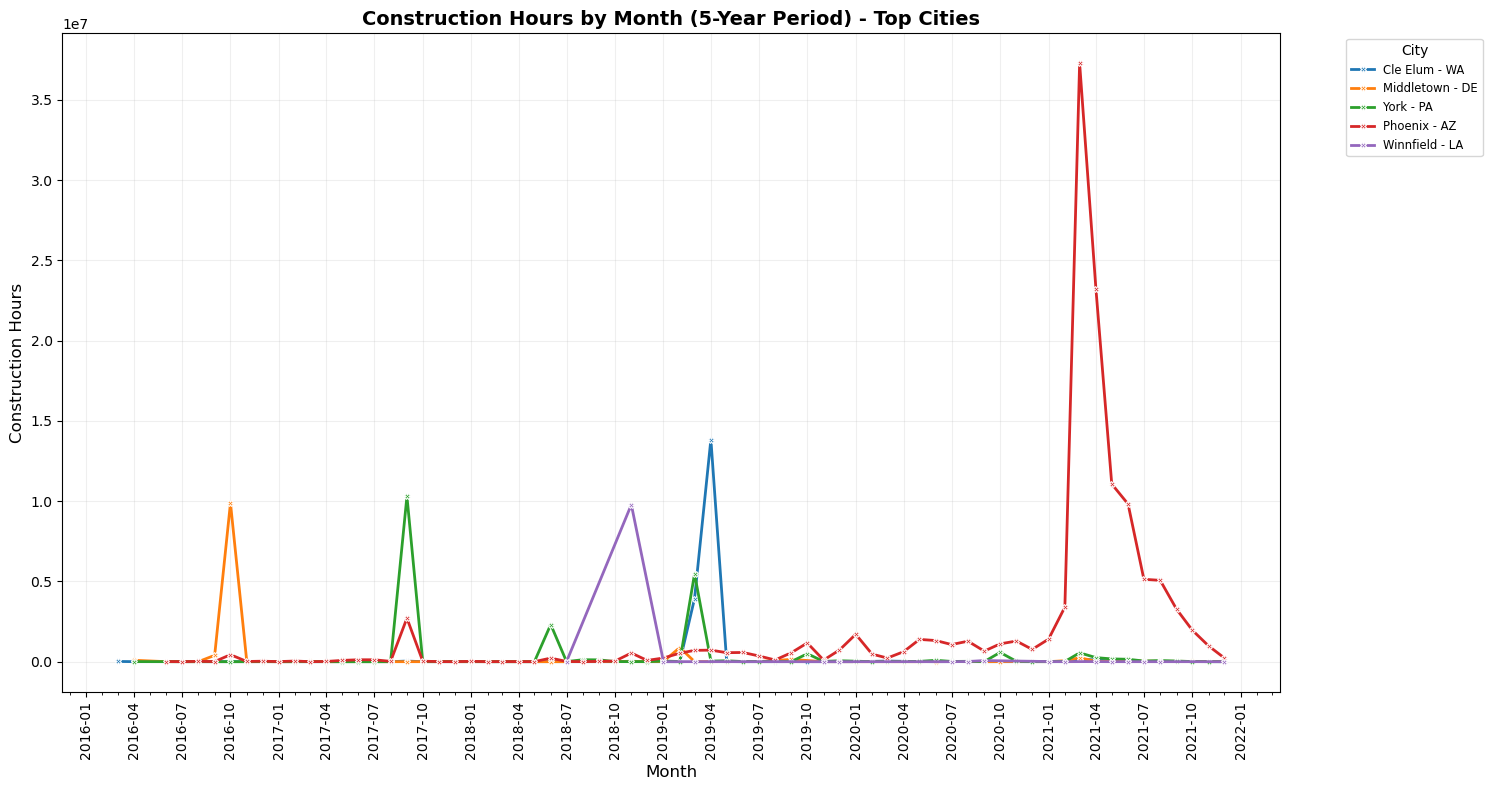

In [40]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_monthly_top_cities, x='month_year_dt', y='duration',  hue="CityST", linewidth=2, marker='X', markersize=4)

plt.title('Construction Hours by Month (5-Year Period) - Top Cities', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Construction Hours', fontsize=12)
plt.grid(True, alpha=0.2)

# Format x-axis for better monthly display
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='medium')

plt.tight_layout()
plt.show()

##### In terms of the yearly highest cities, Most of the cities with highest construction hours has highest activity in Q3 before Covid, which may have shifted towards Q1 during Covid. 

##### Change of city having highest hour-mile of construction in a given year over 5 years - Monthly changes

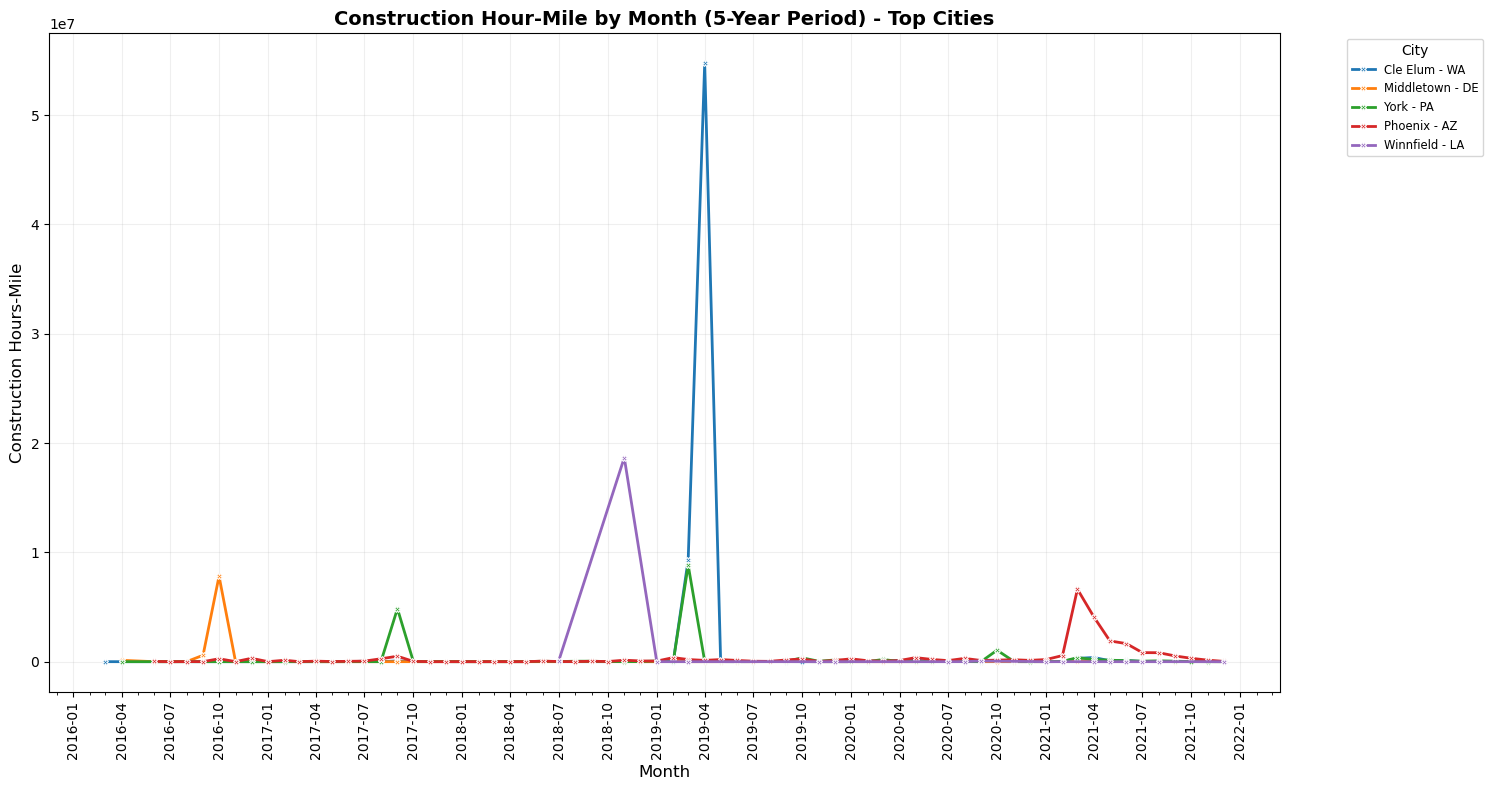

In [41]:
listofcities_7 = list(yearly_construction_hr_mi[yearly_construction_hr_mi['yearly_rank'] == 1]["CityST"].unique())

df_cons_top_cities_hr_mi = df_cons[df_cons["CityST"].isin(listofcities_7)].copy()
df_monthly_top_cities_hr_mi = df_cons_top_cities.groupby(['month_year', "CityST"])['hr-mi'].sum().reset_index()

df_monthly_top_cities_hr_mi['month_year_dt'] = df_monthly_top_cities_hr_mi['month_year'].dt.to_timestamp()
df_monthly_top_cities_hr_mi = df_monthly_top_cities_hr_mi.sort_values('month_year_dt')

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_monthly_top_cities_hr_mi, x='month_year_dt', y='hr-mi',  hue="CityST", linewidth=2, marker='X', markersize=4)

plt.title('Construction Hour-Mile by Month (5-Year Period) - Top Cities', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Construction Hours-Mile', fontsize=12)
plt.grid(True, alpha=0.2)

# Format x-axis for better monthly display
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='medium')

plt.tight_layout()
plt.show()

##### Hour-miles shows similar time series trend as hours

#### 3. If we account for varying city sizes (pick your metric) how do the 10 largest cities in the US compare?

##### The cities to investigate are: (please present either a table or chart comparing these)
 - New York
 - Los Angeles
 - Chicago
 - Houston
 - Phoenix
 - San Antonio
 - Philadelphia
 - San Diego
 - Dallas
 - Austin

There are a number of matrices we can use to define the city size. Those are:
- **Population**: -> One of the most common matric -> Source: Census
- **Area**: -> Another common matric -> Source: Census
- **Employment**: -> Commonly used for _**frieght**_ related matric -> Source: Census
- **Road Network Length**: -> Commonly used for density matric for urban non-urban differenciation -> Source: ArcGIS HUb account for National Highway System GIS
- **Freight Road Network Length**: -> Could be interesting one to consider since the network is specific to _**truck road network**_ -> Source: FAF/BTS website for National Highway Freight Network GIS
- **Freight Vehicle (Truck) Registration**: Could be another interesting one to consider since this is specific to _**truck population**_ -> Source: BTS webpage for National VIUS 2021

#### First lets compare the cities' construction activity regardless of the size of the city...

In [42]:
# List of the 10 largest cities in the US
largest_cities = [
    "New York - NY",
    "Los Angeles - CA",
    "Chicago - IL",
    "Houston - TX",
    "Phoenix - AZ",
    "San Antonio - TX",
    "Philadelphia - PA",
    "San Diego - CA",
    "Dallas - TX",
    "Austin - TX"
]

# Get only these largest 10 cities
largest_cities_df = df_cons[df_cons['CityST'].isin(largest_cities)]
largest_city_construction = largest_cities_df.groupby('CityST')['duration'].sum().reset_index()

# Sort cities
largest_city_construction = largest_city_construction.sort_values(by='duration', ascending=False)
largest_city_construction.reset_index(drop=True, inplace=True)

largest_city_construction['duration'] = largest_city_construction['duration'].astype(int).map(lambda x: f"{x:,}")
print("Top 10 largest cities in the US by construction duration:")
print(largest_city_construction)

Top 10 largest cities in the US by construction duration:
              CityST     duration
0       Phoenix - AZ  125,651,161
1      New York - NY   44,081,413
2       Chicago - IL   31,014,692
3       Houston - TX   22,194,413
4  Philadelphia - PA   12,979,483
5        Dallas - TX   10,802,746
6   Los Angeles - CA    9,681,917
7   San Antonio - TX    4,742,294
8        Austin - TX    2,983,737
9     San Diego - CA    2,189,617


##### Phoenix has the highest hours of construction of the large 10 cities. Compared to the second highest, NYC, Phoenix is 285% higher - So the time period wise, the city looks very high impactful city. However, since we have not normalized the effect size this is still not a apple-to-apple comparison. 

#### Lets compare the hour-miles without considering size of the cities

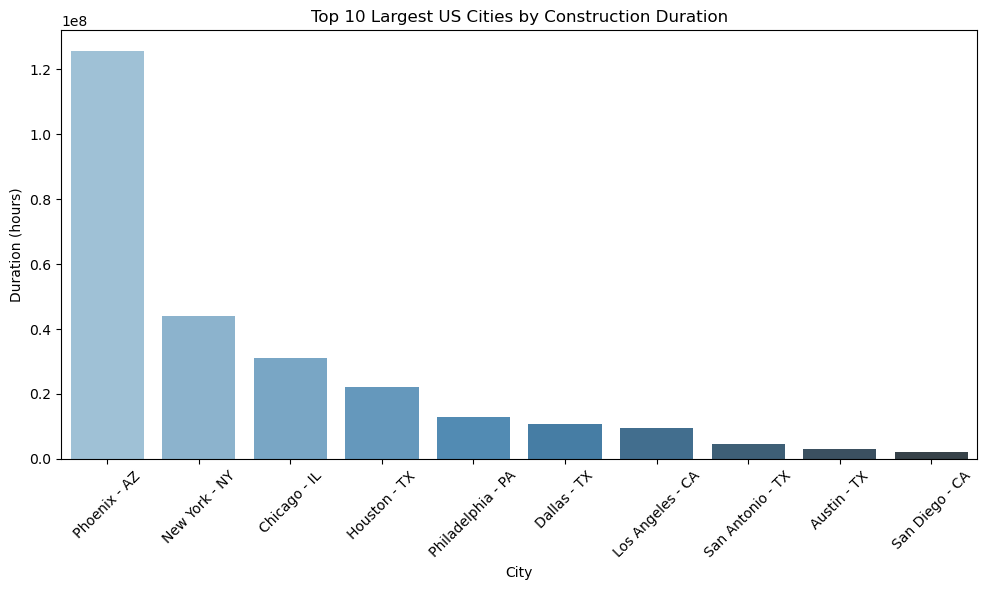

In [43]:
largest_city_construction['duration'] = largest_city_construction['duration'].str.replace(",", "").astype(float)

plt.figure(figsize=(10, 6))
sns.barplot(data=largest_city_construction, x='CityST', y='duration', palette='Blues_d')
plt.title('Top 10 Largest US Cities by Construction Duration')
plt.xlabel('City')
plt.ylabel('Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Phoenix has the highest hours of construction of the large 10 cities. Compared to the second highest, NYC, Phoenix is 285% higher - So the time period wise, the city looks very high impactful city. However, since we have not normalized the effect size this is still not a apple-to-apple comparison. 

#### Lets compare the hour-miles without considering size of the cities

In [44]:
# Group by city and sum the duration
largest_city_construction_hr_mi = largest_cities_df.groupby('CityST')['hr-mi'].sum().reset_index()

# Sort by duration in descending order
largest_city_construction_hr_mi = largest_city_construction_hr_mi.sort_values(by='hr-mi', ascending=False)

largest_city_construction_hr_mi['hr-mi'] = largest_city_construction_hr_mi['hr-mi'].astype(int).map(lambda x: f"{x:,}")
print("Top 10 largest cities in the US by construction duration:")
print(largest_city_construction_hr_mi)

Top 10 largest cities in the US by construction duration:
              CityST       hr-mi
7       Phoenix - AZ  23,348,515
1       Chicago - IL  21,181,316
3       Houston - TX  17,238,271
5      New York - NY  11,436,440
2        Dallas - TX   9,209,791
6  Philadelphia - PA   8,222,395
8   San Antonio - TX   4,406,313
4   Los Angeles - CA   3,474,555
0        Austin - TX   2,425,560
9     San Diego - CA   1,310,381


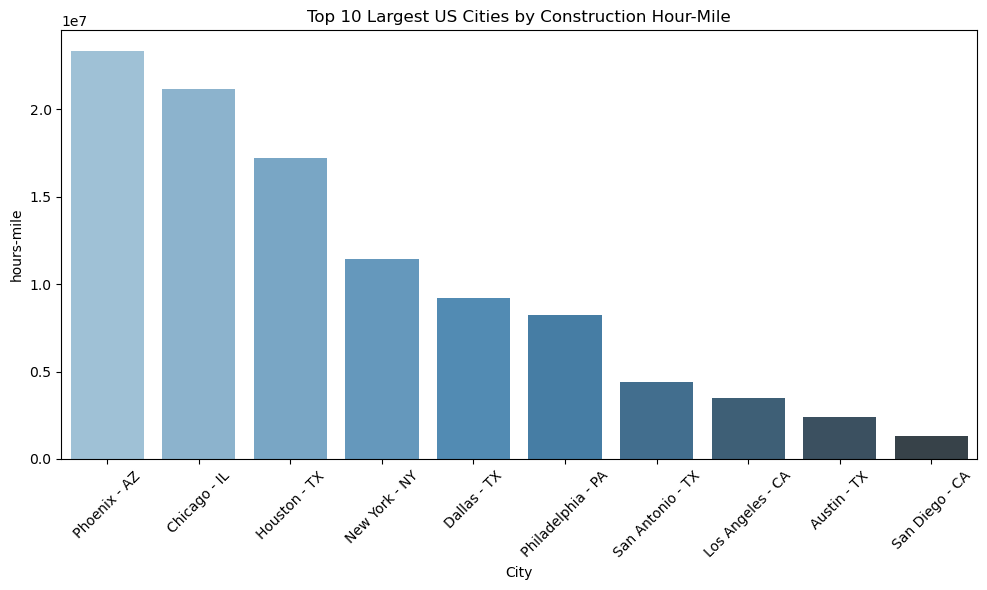

In [45]:
largest_city_construction_hr_mi['hr-mi'] = largest_city_construction_hr_mi['hr-mi'].str.replace(",", "").astype(float)

plt.figure(figsize=(10, 6))
sns.barplot(data=largest_city_construction_hr_mi, x='CityST', y='hr-mi', palette='Blues_d')
plt.title('Top 10 Largest US Cities by Construction Hour-Mile')
plt.xlabel('City')
plt.ylabel('hours-mile')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Like the hour, Phoenix has the highest hours-miles for the city's road construction over 5 years among the large 10 cities. However, unlike the hours, the variation of the exposure effect (hour-miles) got tightened significantly. NYC changed the ranks of 4th where it ranked 2nd with hours of construction. San Deigo and Austin has lowest of all ten cities both in hour (effect on operation day) and hour-miles (exposure effect on operated miles).

#### Now lets consider the size of the cities

In [ ]:
# Google Drive direct download URL
city_url = "https://drive.google.com/uc?export=download&id=1qpx8iktc2wfwCE_2sMv5ODaB3PV4z7HH"

# Fetch the file
response = requests.get(city_url)
response.raise_for_status() 

# Load into pandas from memory
city_stats = gpd.read_parquet(io.BytesIO(response.content))
#city_stats = pd.read_csv(join(par_dir, "data", "city_stats.csv"))
city_stats

,CityST,NHFN Length (mi),Population (2021),FAF Length (mi),Area (sq-mi),Employment
0,Houston - TX,190.6,"2,291,070","1,700.00",671.7,1116179
1,New York - NY,112.4,"8,453,772","1,519.20",472.4,4163589
2,Los Angeles - CA,153.8,"3,830,987","1,455.90",501.6,1967509
3,San Antonio - TX,135.0,"1,454,238","1,028.30",504.2,683426
4,Dallas - TX,102.7,"1,290,070",824.8,383.5,659018
5,Phoenix - AZ,64.6,"1,625,132",768.2,519.3,795784
6,San Diego - CA,96.4,"1,374,972",736.3,372.4,696306
7,Austin - TX,27.7,"969,940",729.8,326.5,555606
8,Chicago - IL,97.8,"2,706,324",598.6,234.5,1381228
9,Philadelphia - PA,44.9,"1,589,918",424.9,142.7,731358


#### All these matric gives a various ways to consider size of the cities.
##### **Employment** ptovides way common KPI to show freight attractions - this might be useful for identifying the market. However, **Population** provides insight on overall traffic demand in the city - therefore for identifying impedence on road construction population might be better and easier matric to consider.

##### For another interesting perecpective we will also consider total **Freight Analysis Framework (FAF)'s highway assignment network** ran trhough the city. We overlayed the FAF network with the Census place shapefile on QGIS to get the FAF road network length in miles for the above mentioned ten cities. It is to be noted that, we did not considered Ferry or centroid connectors, but we included all the local road and ramps, even with low speed of 15 mph.

##### Lets start with population first:

In [47]:
city_stats = city_stats[["CityST", "Population (2021)", "FAF Length (mi)"]]
city_stats['Population (2021)'] = city_stats['Population (2021)'].str.replace(',', '').astype(float)
city_stats['FAF Length (mi)'] = city_stats['FAF Length (mi)'].str.replace(',', '').astype(float)

city_stats["population_rank"] = city_stats['Population (2021)'].rank(method='first', ascending=False)
city_stats["FAF_rank"] = city_stats['FAF Length (mi)'].rank(method='first', ascending=False)
city_stats = city_stats.sort_values(by='Population (2021)', ascending=False)

display(city_stats)

,CityST,Population (2021),FAF Length (mi),population_rank,FAF_rank
1,New York - NY,8453772.0,1519.2,1.0,2.0
2,Los Angeles - CA,3830987.0,1455.9,2.0,3.0
8,Chicago - IL,2706324.0,598.6,3.0,9.0
0,Houston - TX,2291070.0,1700.0,4.0,1.0
5,Phoenix - AZ,1625132.0,768.2,5.0,6.0
9,Philadelphia - PA,1589918.0,424.9,6.0,10.0
3,San Antonio - TX,1454238.0,1028.3,7.0,4.0
6,San Diego - CA,1374972.0,736.3,8.0,7.0
4,Dallas - TX,1290070.0,824.8,9.0,5.0
7,Austin - TX,969940.0,729.8,10.0,8.0


##### Clearly we can see the two different matric placed different ranked cities in the list - NYC is largest based on population, but ranked second in regards to Freight road network. Simlarly, Philadelphia is the smallest of all the 10 largest cities considering freight road network, while it is much larger city when considered population size.

In [48]:
largest_city_construction = largest_city_construction.merge(city_stats, on='CityST', how='left')
largest_city_construction

,CityST,duration,Population (2021),FAF Length (mi),population_rank,FAF_rank
0,Phoenix - AZ,125651161.0,1625132.0,768.2,5.0,6.0
1,New York - NY,44081413.0,8453772.0,1519.2,1.0,2.0
2,Chicago - IL,31014692.0,2706324.0,598.6,3.0,9.0
3,Houston - TX,22194413.0,2291070.0,1700.0,4.0,1.0
4,Philadelphia - PA,12979483.0,1589918.0,424.9,6.0,10.0
5,Dallas - TX,10802746.0,1290070.0,824.8,9.0,5.0
6,Los Angeles - CA,9681917.0,3830987.0,1455.9,2.0,3.0
7,San Antonio - TX,4742294.0,1454238.0,1028.3,7.0,4.0
8,Austin - TX,2983737.0,969940.0,729.8,10.0,8.0
9,San Diego - CA,2189617.0,1374972.0,736.3,8.0,7.0


##### Normalization

In [49]:
#largest_city_construction['duration'] = largest_city_construction['duration'].str.replace(',', '').astype(float)

largest_city_construction['duration_per_1mil_pop'] = (
	largest_city_construction['duration']*1_000_000 /
	largest_city_construction['Population (2021)']
)

largest_city_construction['duration_per_1k_road'] = (
	largest_city_construction['duration']*1_000 /
	largest_city_construction['FAF Length (mi)']
)

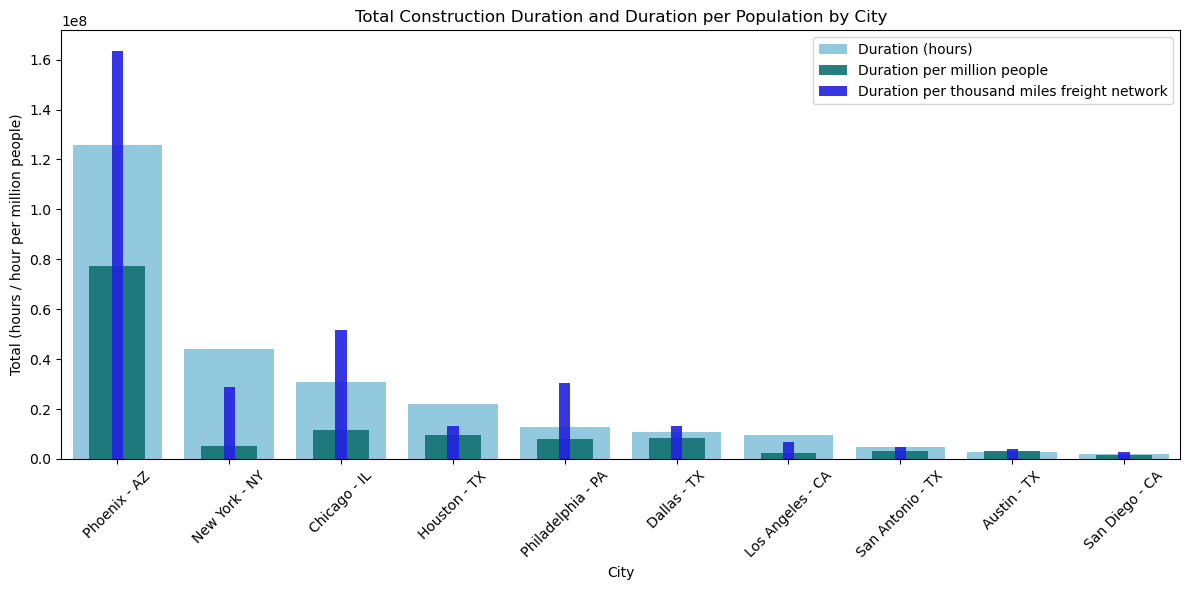

In [50]:
plt.figure(figsize=(12, 6))
# duration bar
sns.barplot(data=largest_city_construction, x='CityST', y=largest_city_construction['duration'], color='skyblue', label='Duration (hours)')
# normalized by Population
sns.barplot(data=largest_city_construction, x='CityST', y='duration_per_1mil_pop', color='teal', alpha=0.9, label='Duration per million people', width=0.5)
# normalized by Road Length
sns.barplot(data=largest_city_construction, x='CityST', y='duration_per_1k_road', color='blue', alpha=0.9, label='Duration per thousand miles freight network', width=0.1)
plt.title('Total Construction Duration and Duration per Population by City')
plt.xlabel('City')
plt.ylabel('Total (hours / hour per million people)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# Rank the cities
largest_city_construction["rank"] = largest_city_construction['duration'].rank(method='first', ascending=False)
largest_city_construction["pop_rank"] = largest_city_construction['duration_per_1mil_pop'].rank(method='first', ascending=False)
largest_city_construction["road_rank"] = largest_city_construction['duration_per_1k_road'].rank(method='first', ascending=False)

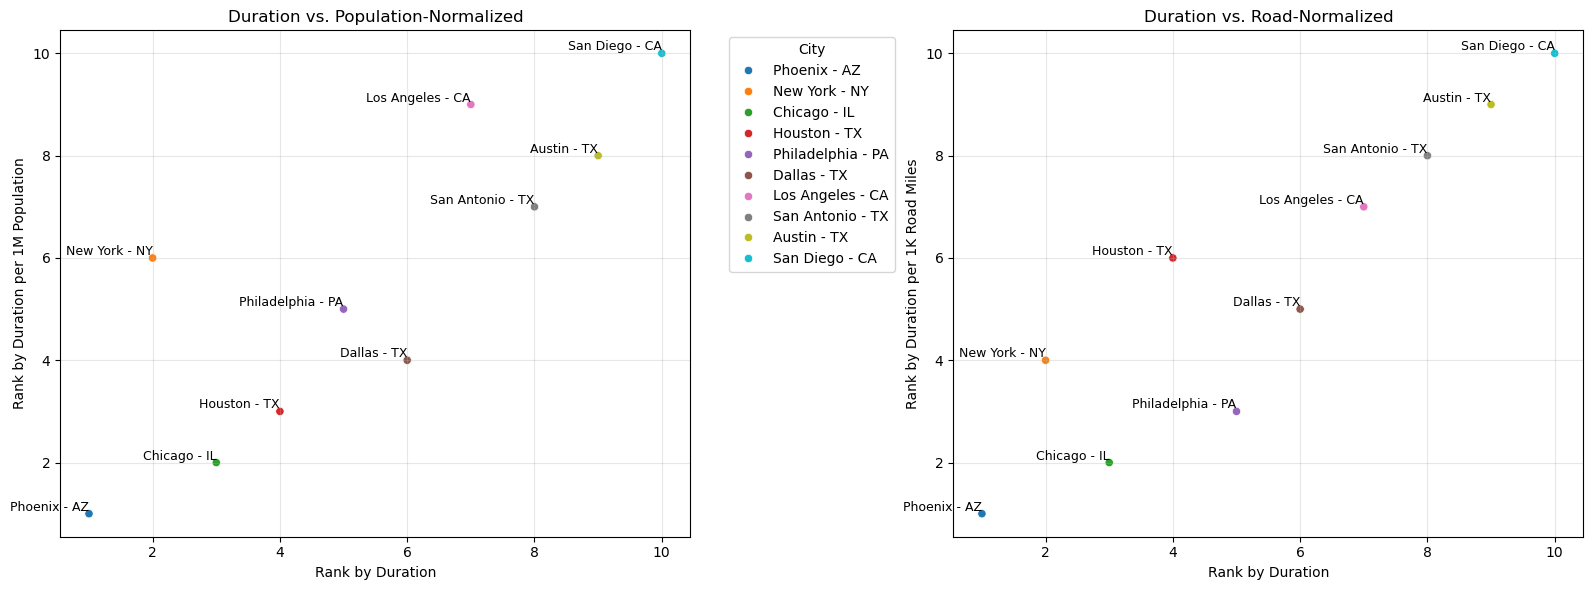

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Population-Normalized plot
sns.scatterplot(
    data=largest_city_construction,
    x="rank",
    y="pop_rank",
    hue="CityST",
    ax=axes[0]
)
axes[0].set_title("Duration vs. Population-Normalized")
axes[0].set_xlabel("Rank by Duration")
axes[0].set_ylabel("Rank by Duration per 1M Population")
axes[0].grid(True, alpha=0.3)
axes[0].legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

# Road-Normalized plot
sns.scatterplot(
    data=largest_city_construction,
    x="rank",
    y="road_rank",
    hue="CityST",
    ax=axes[1],
    legend=False
)
axes[1].set_title("Duration vs. Road-Normalized")
axes[1].set_xlabel("Rank by Duration")
axes[1].set_ylabel("Rank by Duration per 1K Road Miles")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
for i, row in largest_city_construction.iterrows():
    axes[0].text(row["rank"], row["pop_rank"], row["CityST"], fontsize=9, ha='right', va='bottom')
    axes[1].text(row["rank"], row["road_rank"], row["CityST"], fontsize=9, ha='right', va='bottom')

plt.show()

##### Normalized version overall changed the effect we observe in almost all the cities. However, choice of  matric may have a huge impact on how we would see the impact of constraction impact. For example NYC, LA, and Philadelphia show a higher impact when we considered the freight road lenght as the size of the city. This make sense since both LA and NY has major ports for freight movement and intermodal facilities in Port of NY-NJ and Port of LA-LB.
##### On the other hand Houston shows the impact has greater impact when we consider the over all traffic demand from a proxy KPI of population.

#### Regardless of the matric we used normalized version of the duration shows city of **Phoenix, AZ** and **Chicago, IL** are top most and third most impactful cities respectively

#### 4. We have 5 potential self-driving routes (csv attached). Based on the provided data, if we want to operate an AV vehicle along one of these routes throughout a year, which Aurora route do you think poses the greatest risk of autonomy challenges because of construction?

##### First we would consider all the constructions has at least one of either start or end location with in the bounding box of route shapefile

In [53]:
df_cons_sf = df_cons[
    ((df_cons['Start_Lng'] >= min_x) & (df_cons['Start_Lng'] <= max_x) &
     (df_cons['Start_Lat'] >= min_y) & (df_cons['Start_Lat'] <= max_y)) |
    ((df_cons['End_Lng'] >= min_x) & (df_cons['End_Lng'] <= max_x) &
     (df_cons['End_Lat'] >= min_y) & (df_cons['End_Lat'] <= max_y))
]
df_cons_sf.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,start_date,end_date,year,duration,CityST,hr-mi,month_year
167,C-172,2,2018-11-13 07:30:00,2018-11-13 17:00:00.000000000,37.851181,-122.280014,NaN,NaN,0.000000,Intermittent lane closures due to construction...,...,Day,Day,Day,2018-11-13 07:30:00,2018-11-13 17:00:00,2018,9.500000,Berkeley - CA,0.000000,2018-11
330,C-337,1,2019-08-14 03:38:26,2019-12-30 23:59:00.000000000,37.770088,-122.413063,NaN,NaN,0.130000,Road closed due to construction on 12th St bot...,...,Night,Night,Night,2019-08-14 03:38:26,2019-12-30 23:59:00,2019,3332.342778,San Francisco - CA,433.204545,2019-08
454,C-463,2,2021-07-28 09:15:00,2021-07-28 13:30:00.000000000,37.795554,-122.266298,37.794884,-122.266738,0.052155,Lane closure due to Emergency Work between Rou...,...,Day,Day,Day,2021-07-28 09:15:00,2021-07-28 13:30:00,2021,4.250000,Oakland - CA,0.221658,2021-07
557,C-569,2,2021-10-10 16:01:00,2021-10-10 18:46:00.000000000,37.813723,-122.361406,37.807951,-122.367478,0.518561,Lane closure due to Special Event between E/En...,...,Day,Day,Day,2021-10-10 16:01:00,2021-10-10 18:46:00,2021,2.750000,San Francisco - CA,1.426043,2021-10
586,C-598,2,2019-06-27 15:04:48,2019-07-01 15:00:00.000000000,37.631870,-122.418370,37.634160,-122.419680,0.173703,At I-380 - Construction work.,...,Day,Day,Day,2019-06-27 15:04:48,2019-07-01 15:00:00,2019,95.920000,San Bruno - CA,16.661627,2019-06


In [54]:
len(df_cons_sf)

32600

##### We get 32,600 construction in the bounding box. If we map those instruction we get the construction heatmap for the whole period in the bay area CA. See below:

In [55]:
get_heatmap(df = df_cons_sf, latcol = 'Start_Lat', longcol = 'Start_Lng')

Map(center=[np.float64(37.770091778834356), np.float64(-122.36850635346624)], controls=(ZoomControl(options=['…

San Fransisco has a very densed area of construction hotstops. This poses a high vulneribility to almost all the routes we are considering.

##### However, this does not provide duration of construction which poses additional threat to operations. Lets explore the duration heatmap as below:

In [56]:
#from ipyleaflet import Map, Heatmap, GeoData, LayersControl, basemaps

def get_heatmap_with_weight(df, latcol, longcol, weightcol):
    
    data = df[[latcol, longcol, weightcol]].dropna()
    
    data = data.groupby([latcol, longcol], as_index=False)[weightcol].sum()
    data = data[[latcol, longcol, weightcol]].values.tolist()

    center = [df[latcol].mean(), df[longcol].mean()]
    m = Map(center=center, zoom=11, basemap=basemaps.CartoDB.DarkMatter, scroll_wheel_zoom = True, layout={'height': '650px'})

    heatmap = Heatmap(locations=data, radius=12, blur=10, min_opacity=0.4, name=f'Construction {weightcol} Heatmap')
    m.add_layer(heatmap)

    routes_layer = GeoData(
        geo_dataframe=df_routes,
        style_callback=lambda feat: {
            'color': color_map.get(feat['properties']['path_name'], 'white'),
            'weight': 4,
            'opacity': 0.7
        },
        name='Routes',
        hover_style={'fillColor': 'yellow', 'color': 'yellow', 'weight': 6, 'fillOpacity': 0.2},
        tooltip=True,
        tooltip_property='path_name'
    )
    m.add_layer(routes_layer)

    m.add_control(LayersControl())

    return m

In [57]:
get_heatmap_with_weight(df = df_cons_sf, latcol = 'Start_Lat', longcol = 'Start_Lng', weightcol = 'duration')

Map(center=[np.float64(37.770091778834356), np.float64(-122.36850635346624)], controls=(ZoomControl(options=['…

The Duration heatmap does not show any conclusive insight as is now. However, shows a number of constraction sites not affacting the route directly.

##### Therefore in next step we would map the start and end point to the route to snap a point on the route. For simplicity we would consider about 20 m radius to snap on the road - considering the linestring provided the centerline of the route.

##### Few more Feature Extractions:

##### Closed Road/Lane or Others - extracted from description

In [67]:
df_cons_sf["Description"] = df_cons_sf["Description"].str.lower()
df_cons_sf["closed"] = df_cons_sf["Description"].str.contains("closed")
df_cons_sf["road_closure"] = np.where(
    df_cons_sf["closed"] == True,
    "Road/Lane closed",
    "Other construction")
df_cons_sf["road_closure"].value_counts(normalize=True)

road_closure
Other construction    0.596074
Road/Lane closed      0.403926
Name: proportion, dtype: float64

##### Almost **40%** of the construction in Bay Area, CA involved full road closure or lane closure

In [68]:
# Iteration for creating arrays of route nodes
route_points = []
route_path_names = []
for idx, row in df_routes.iterrows():
    geom = row.geometry
    if geom.geom_type == 'LineString':
        coords = list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        coords = [pt for line in geom for pt in line.coords]
    else:
        continue
    for lon, lat in coords:
        route_points.append((lat, lon))
        route_path_names.append(row['path_name'])

route_points = np.array(route_points)
route_path_names = np.array(route_path_names)

# Build KDTree
tree = cKDTree(route_points)

# Prepare construction nodes
cons_points = []
cons_ids = []
cons_durations = []
cons_distances = []
cons_types = []
cons_year = []
cons_Severity = []
cons_road_closure = []
for idx, row in df_cons_sf.iterrows():
    if not np.isnan(row['Start_Lat']) and not np.isnan(row['Start_Lng']):
        cons_points.append((row['Start_Lat'], row['Start_Lng']))
        cons_ids.append(row['ID'])
        cons_durations.append(row['duration'])
        cons_distances.append(row['Distance(mi)'])
        cons_year.append(row['year'])
        cons_types.append('start')
        cons_Severity.append(row['Severity'])
        cons_road_closure.append(row['road_closure'])
    if not np.isnan(row['End_Lat']) and not np.isnan(row['End_Lng']):
        cons_points.append((row['End_Lat'], row['End_Lng']))
        cons_ids.append(row['ID'])
        cons_durations.append(row['duration'])
        cons_distances.append(row['Distance(mi)'])
        cons_year.append(row['year'])        
        cons_types.append('end')
        cons_Severity.append(row['Severity'])
        cons_road_closure.append(row['road_closure'])

cons_points = np.array(cons_points)

# Query KDTree for all nodes to match - thresholds: 0.001 deg ~ 100m; 0.00018 deg ~ 20m
#threshold = 0.001
threshold = 0.00018
matches = tree.query_ball_point(cons_points, r=threshold)

# Get info for matching nodes in query
output_rows = []
for i, route_idxs in enumerate(matches):
    for route_idx in route_idxs:
        output_rows.append({
            'ID': cons_ids[i],
            'duration': cons_durations[i],
            'distance_mi': cons_distances[i],
            'lat': cons_points[i][0],
            'lng': cons_points[i][1],
            'path_name': route_path_names[route_idx],
            'year': cons_year[i],
            'Severity': cons_Severity[i],
            'road_closure': cons_road_closure[i],
            'match_type': cons_types[i]
        })

matched_df = pd.DataFrame(output_rows)
display(matched_df.head())

,ID,duration,distance_mi,lat,lng,path_name,year,Severity,road_closure,match_type
0,C-1441,4.994722,0.455351,37.710290,-122.465650,SF -> Pacifica,2019,4,Road/Lane closed,start
1,C-2301,12.000000,0.286463,37.829122,-122.293805,SF -> Berkley,2020,2,Other construction,end
2,C-4847,59.989722,1.614019,37.905550,-122.515240,SF -> San Rafael,2019,2,Other construction,end
3,C-9228,0.762778,0.000000,37.926052,-122.514549,SF -> San Rafael,2019,2,Road/Lane closed,start
4,C-10026,3025.986111,3.291468,37.770949,-122.405755,SF -> Berkley,2021,2,Other construction,start


##### Drop one row if matched both start and end

In [69]:
del matched_df['match_type']
matched_df.drop_duplicates(inplace=True)
len(matched_df)

9197

#### We finally got slightly over 9,000 construction between 2016 and 2021 that affected the routes Out of those the distribution of the constructions by route are:

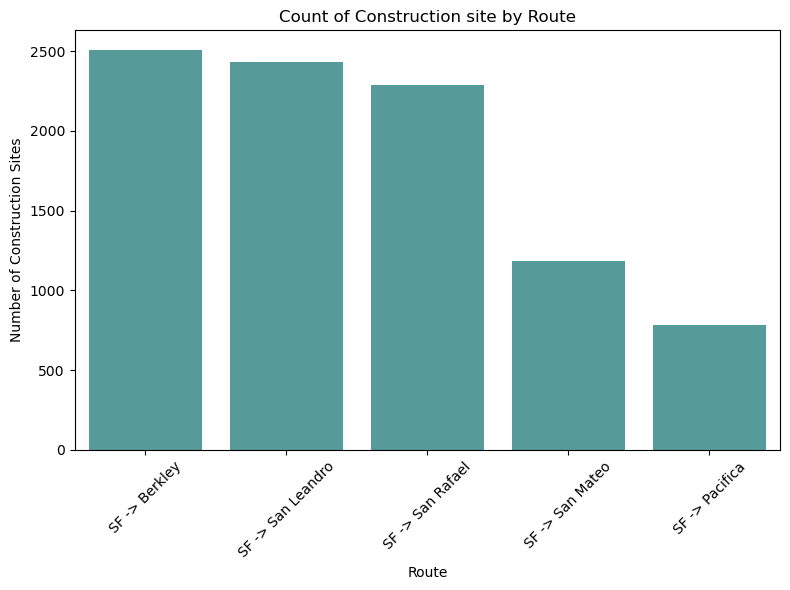

In [70]:
plt.figure(figsize=(8, 6))
sns.countplot(data=matched_df, x='path_name', order=matched_df['path_name'].value_counts().index, color='teal', alpha=0.7)
plt.title('Count of Construction site by Route')
plt.xlabel('Route')
plt.ylabel('Number of Construction Sites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **SF -> Pacifica** has least number of constructions between 2016 and 2021

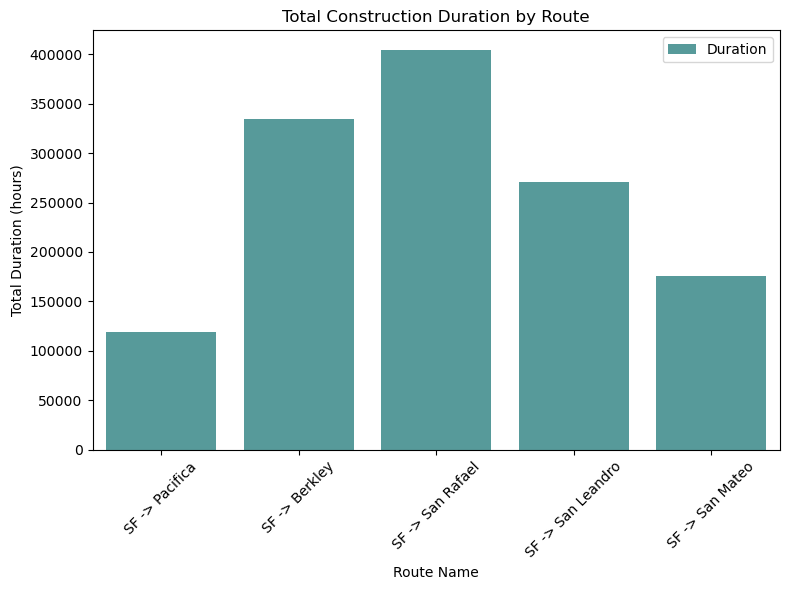

In [71]:
plt.figure(figsize=(8, 6))
sns.barplot(data=matched_df, x='path_name', y='duration', color='teal', label='Duration', estimator=sum, alpha = 0.7, ci=None)
plt.title('Total Construction Duration by Route')
plt.xlabel('Route Name')
plt.ylabel('Total Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **SF -> Pacifica** also rank top with lower constructions hours between 2016 and 2021

In [72]:
get_heatmap_with_weight(df = matched_df, latcol = 'lat', longcol = 'lng', weightcol = 'duration')

Map(center=[np.float64(37.7835583827335), np.float64(-122.39261167489397)], controls=(ZoomControl(options=['po…

##### Visually, the route **SF -> Pacifica** also shows lower density of construction hotspots.

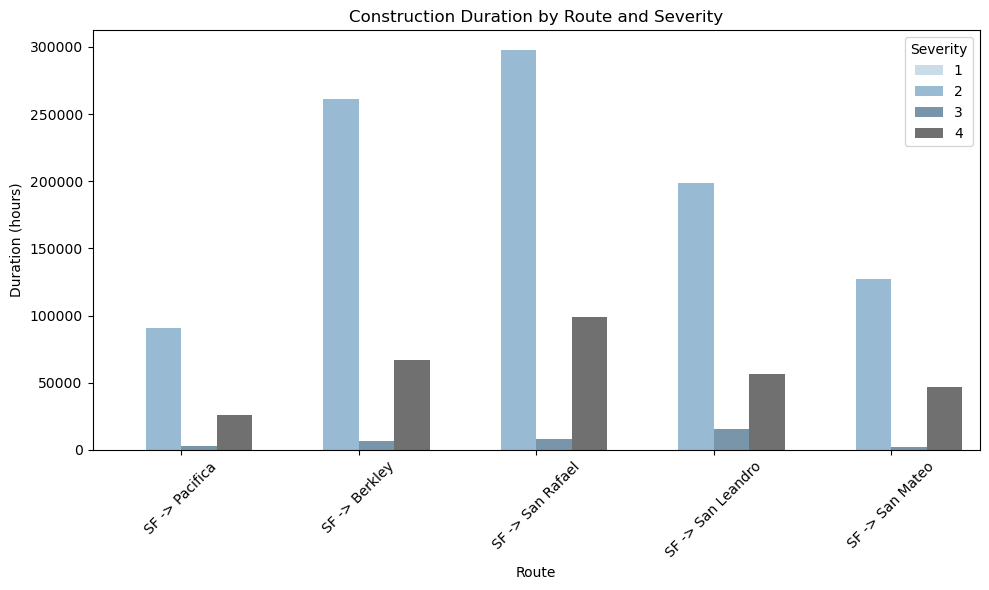

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(data=matched_df, x='path_name', y='duration', hue='Severity', estimator=sum, ci=None, palette='Blues_d', alpha=0.7)
plt.title('Construction Duration by Route and Severity')
plt.xlabel('Route')
plt.ylabel('Duration (hours)')
plt.xticks(rotation=45)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

##### **SF -> Pacifica** also shows lowest number of construction with higher severity

In [78]:
matched_df["road_closure_event"] = np.where(
    matched_df["road_closure"] == "Road/Lane closed",
    2,
    1)
matched_df["road_closure_event"] = matched_df["road_closure_event"].astype(int)

In [79]:
matched_df.head()

,ID,duration,distance_mi,lat,lng,path_name,year,Severity,road_closure,road_closure_event
0,C-1441,4.994722,0.455351,37.710290,-122.465650,SF -> Pacifica,2019,4,Road/Lane closed,2
1,C-2301,12.000000,0.286463,37.829122,-122.293805,SF -> Berkley,2020,2,Other construction,1
2,C-4847,59.989722,1.614019,37.905550,-122.515240,SF -> San Rafael,2019,2,Other construction,1
3,C-9228,0.762778,0.000000,37.926052,-122.514549,SF -> San Rafael,2019,2,Road/Lane closed,2
4,C-10026,3025.986111,3.291468,37.770949,-122.405755,SF -> Berkley,2021,2,Other construction,1


Considering Road Closure event as severity 2 while others as 1

In [80]:
#summary = matched_df.groupby("path_name").mean(numeric_only=True)
#summary = matched_df.groupby("path_name").median(numeric_only=True)
summary = matched_df.groupby("path_name").sum(numeric_only=True)
#summary = summary[["duration", "hr-mi"]]
summary = summary[["duration", "distance_mi", "Severity", "road_closure_event"]]
display(summary)

,duration,distance_mi,Severity,road_closure_event
path_name,,,,
SF -> Berkley,334837.733611,3877.456910,5686,3204
SF -> Pacifica,118943.190556,917.132645,1947,1050
SF -> San Leandro,270870.901667,4223.583655,5615,3112
SF -> San Mateo,175942.188889,1144.614060,2757,1593
SF -> San Rafael,403901.347222,2723.727824,4855,2854


#### Get a Score for each route to compare

##### invert normalization

In [81]:
norm = 1 - (summary - summary.min()) / (summary.max() - summary.min())
norm

,duration,distance_mi,Severity,road_closure_event
path_name,,,,
SF -> Berkley,0.242364,0.104682,0.000000,0.000000
SF -> Pacifica,1.000000,1.000000,1.000000,1.000000
SF -> San Leandro,0.466842,0.000000,0.018989,0.042711
SF -> San Mateo,0.799974,0.931201,0.783365,0.747911
SF -> San Rafael,0.000000,0.453615,0.222252,0.162488


##### Assign weight according to standard deviations

In [82]:
stds = summary.std()
stds

duration              115526.142118
distance_mi             1519.115172
Severity                1717.103957
road_closure_event       978.037729
dtype: float64

In [83]:
weights = stds / stds.sum()
weights

duration              0.964805
distance_mi           0.012687
Severity              0.014340
road_closure_event    0.008168
dtype: float64

##### Assign a Score

In [86]:
summary["Score"] = norm.dot(weights)
summary["Rank"] = summary["Score"].rank(ascending=False)
summary.sort_values(by="Rank", inplace=True)
display(summary)

,duration,distance_mi,Severity,road_closure_event,Score,Rank
path_name,,,,,,
SF -> Pacifica,118943.190556,917.132645,1947,1050,1.000000,1.0
SF -> San Mateo,175942.188889,1144.614060,2757,1593,0.800976,2.0
SF -> San Leandro,270870.901667,4223.583655,5615,3112,0.451033,3.0
SF -> Berkley,334837.733611,3877.456910,5686,3204,0.235162,4.0
SF -> San Rafael,403901.347222,2723.727824,4855,2854,0.010269,5.0


#### **SF -> Pacifica** ranked high on exposing to minimal construction hazards, SF -> San Mateo is the next best candidate to operate.

#### For further exploration we could use the following interactive map to focus on any market segmentation to get more focused data-driven insight.

In [87]:
import ipywidgets as widgets
from ipyleaflet import Map, Heatmap, GeoData, LayersControl, basemaps

# widget for selections
years = sorted(matched_df['year'].dropna().unique())
severity = sorted(matched_df['Severity'].dropna().unique())
road_closure = sorted(matched_df['road_closure'].dropna().unique())


# ToggleButtons
year_toggle = widgets.ToggleButtons(
    options = [('5 Years (2016-2021)', 'all')] + [(str(int(y)), int(y)) for y in years],
    value = 'all',
    description = 'Year:',
    style = {'description_width': 'initial'},
    button_style = 'success', # 'success', 'info', 'warning', 'danger' or ''
)

severity_toggle = widgets.ToggleButtons(
    options = [('All', 'all')] + [(str(int(y)), int(y)) for y in severity],
    value = 'all',
    description = 'Severity:',
    style = {'description_width': 'initial'},
    button_style = 'info', # 'success', 'info', 'warning', 'danger' or ''
)

road_closure_toggle = widgets.ToggleButtons(
    options=[('All', 'all')] + [(y, y) for y in road_closure],
    value='all',
    description='Road/Lane Closure:',
    style={'description_width': 'initial'},
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

def create_heatmap(year, severity, road_closure):
    if year == 'all':
        df = matched_df
    else:
        df = matched_df[matched_df['year'] == year]

    if severity_toggle.value == 'all':
        df = df
    else:
        df = df[df['Severity'] == severity]

    if road_closure_toggle.value == 'all':
        df = df
    else:
        df = df[df['road_closure'] == road_closure]
    
    
    heat_df = df[['lat', 'lng', 'duration']].dropna()
    heat_df = heat_df.groupby(['lat', 'lng'], as_index = False)['duration'].sum()
    heat_data = heat_df[['lat', 'lng', 'duration']].values.tolist()

    center = [matched_df['lat'].mean(), matched_df['lng'].mean()]
    m = Map(center=center, zoom=11, basemap=basemaps.CartoDB.DarkMatter, scroll_wheel_zoom=True, layout={'height': '650px'})

    heatmap = Heatmap(locations=heat_data, radius=12, blur=10, min_opacity=0.4, name='Construction Heatmap')
    m.add_layer(heatmap)

    routes_layer = GeoData(
        geo_dataframe=df_routes,
        style_callback=lambda feat: {
            'color': color_map.get(feat['properties']['path_name'], 'white'),
            'weight': 4,
            'opacity': 0.7
        },
        name='Routes',
        hover_style={'fillColor': 'yellow', 'color': 'yellow', 'weight': 6, 'fillOpacity': 0.2},
        tooltip=True,
        tooltip_property='path_name'
    )
    m.add_layer(routes_layer)
    m.add_control(LayersControl())
    return m

map_output = widgets.Output()

def update_map(change):
    with map_output:
        map_output.clear_output()
        selected_year = year_toggle.value
        selected_severity = severity_toggle.value
        selected_road_closure = road_closure_toggle.value
        display(create_heatmap(selected_year, selected_severity, selected_road_closure))

year_toggle.observe(update_map, names='value')
severity_toggle.observe(update_map, names='value')
road_closure_toggle.observe(update_map, names='value')

# Initialization
with map_output:
    display(create_heatmap('all', 'all', 'all'))

display(widgets.VBox([year_toggle, severity_toggle, road_closure_toggle, map_output]))

#### In scenario testing from above interactive tool we found interesting insight: **SF -> Pacifica** shows no hotspot for Road/Lane closure construction of any severity in any time other than 2019

#### 5. Our operations team wants to know if we can predict how long any given construction project will take to complete. Based on the provided data, is this something that we can predict?

- Baseline model - benchmark:
    - Linear Regression

- Next best model:
    - Random Forest Regression
    - Decision Tree Regressor
    - Gradient Boosting
    - Geospatial models

#### Linear Regression Model

##### Depandent Variable Description

In [88]:
df_cons["duration"] = df_cons["duration"].astype(float)
df_cons["duration"].describe()

count    6.170627e+06
mean     4.370814e+02
std      1.837713e+03
min      5.277778e-03
25%      2.132778e+00
50%      7.308333e+00
75%      3.600000e+01
max      5.085102e+04
Name: duration, dtype: float64

##### Feature Extraction:

In [ ]:
df_cons['quarter'] = df_cons['Start_Time'].dt.quarter

In [98]:
df_cons["Description"] = df_cons["Description"].str.lower()
df_cons["closed"] = df_cons["Description"].str.contains("closed")
df_cons["lane_closed"] = df_cons["Description"].str.contains("lane closed")
df_cons["road_closure"] = np.where(
    df_cons["lane_closed"] == True,
    "Lane closed",
    np.where(
        df_cons["closed"] == True,
        "Road closed",
        "Other construction"))
df_cons["road_closure"].value_counts()

road_closure
Other construction    4986699
Road closed            794866
Lane closed            389062
Name: count, dtype: int64

##### Correlation Heatmap

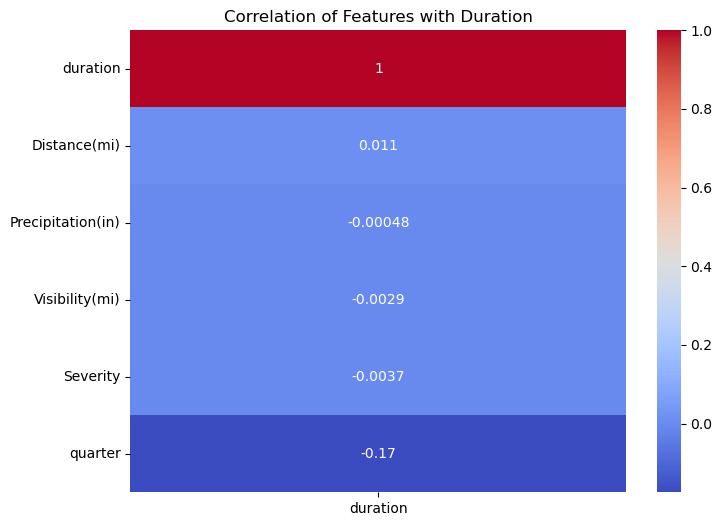

In [ ]:
num_features = ['Severity', 'Distance(mi)', 'Visibility(mi)', 'Precipitation(in)', 'quarter', 'duration']

df_corr = df_cons[num_features].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr()[['duration']].sort_values(by='duration', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Duration')
plt.show()

##### Except Quarter - time period - everything else looks to be weak candidate! However, Quarter is also marginally fine, lets use Severity, distance and quarter for the time-being

#### Box plots for binary features

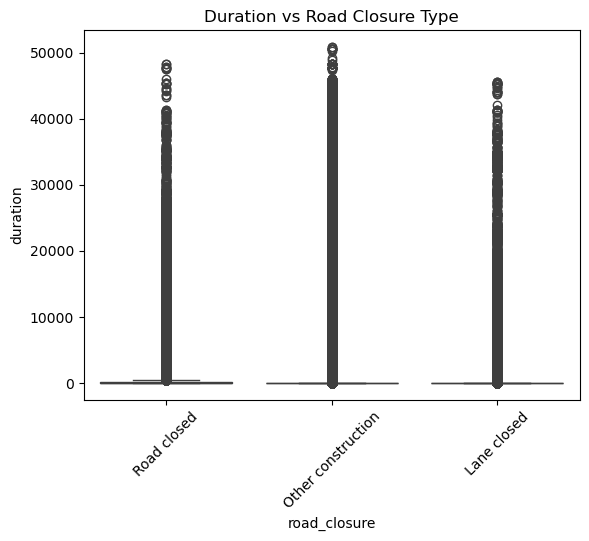

In [99]:
sns.boxplot(x = 'road_closure', y = 'duration', data = df_cons)
plt.xticks(rotation = 45)
plt.title('Duration vs Road Closure Type')
plt.show()

##### The data has a lots of outliars!!! Lets try log scale

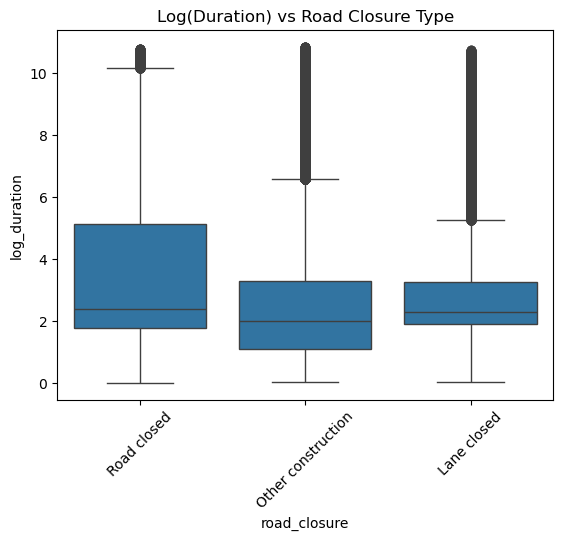

In [ ]:
df_cons['log_duration'] = np.log1p(df_cons['duration'])
sns.boxplot(x='road_closure', y='log_duration', data=df_cons)
plt.xticks(rotation=45)
plt.title('Log(Duration) vs Road Closure Type')
plt.show()

In [100]:
df_cons.groupby('road_closure')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
road_closure,,,,,,,,
Lane closed,389062.0,285.753150,1571.369532,0.051944,5.750000,8.988889,24.853611,45535.883333
Other construction,4986699.0,447.762852,1872.668652,0.025000,2.041111,6.505000,26.000000,50851.019722
Road closed,794866.0,444.140260,1730.887147,0.005278,4.997500,9.750000,168.992083,48215.330000


##### Road closer looks to have higher duration. There are still a significant outliars - espacially for other and lane closure. - This looks an good candidate for predicting the variability of the duration

##### Lets try other binary variables

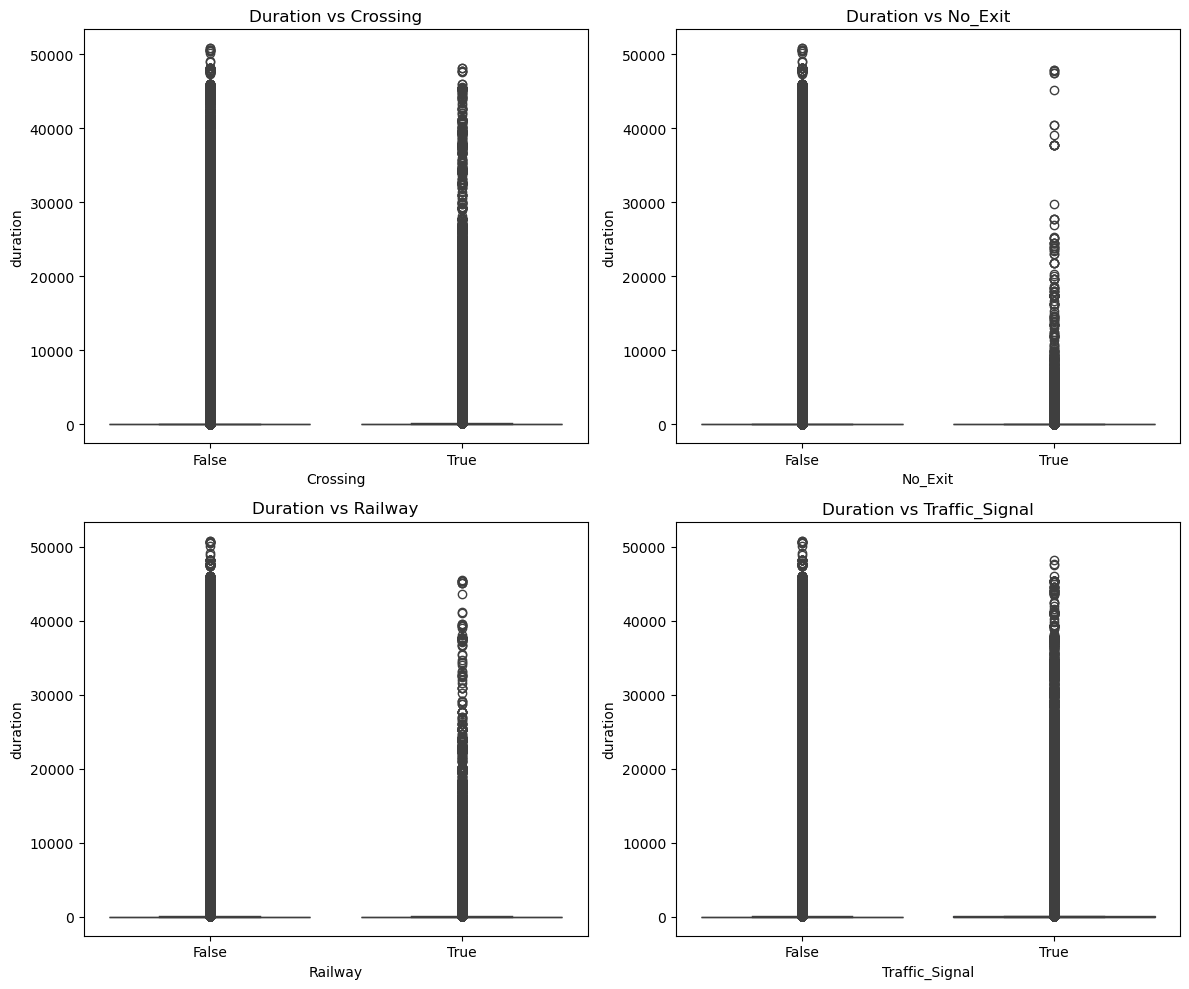

In [ ]:
binary_features = ['Crossing', 'No_Exit', 'Railway', 'Traffic_Signal']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(binary_features):
    sns.boxplot(ax=axes[i], x=col, y='duration', data=df_cons)
    axes[i].set_title(f'Duration vs {col}')

plt.tight_layout()
plt.show()


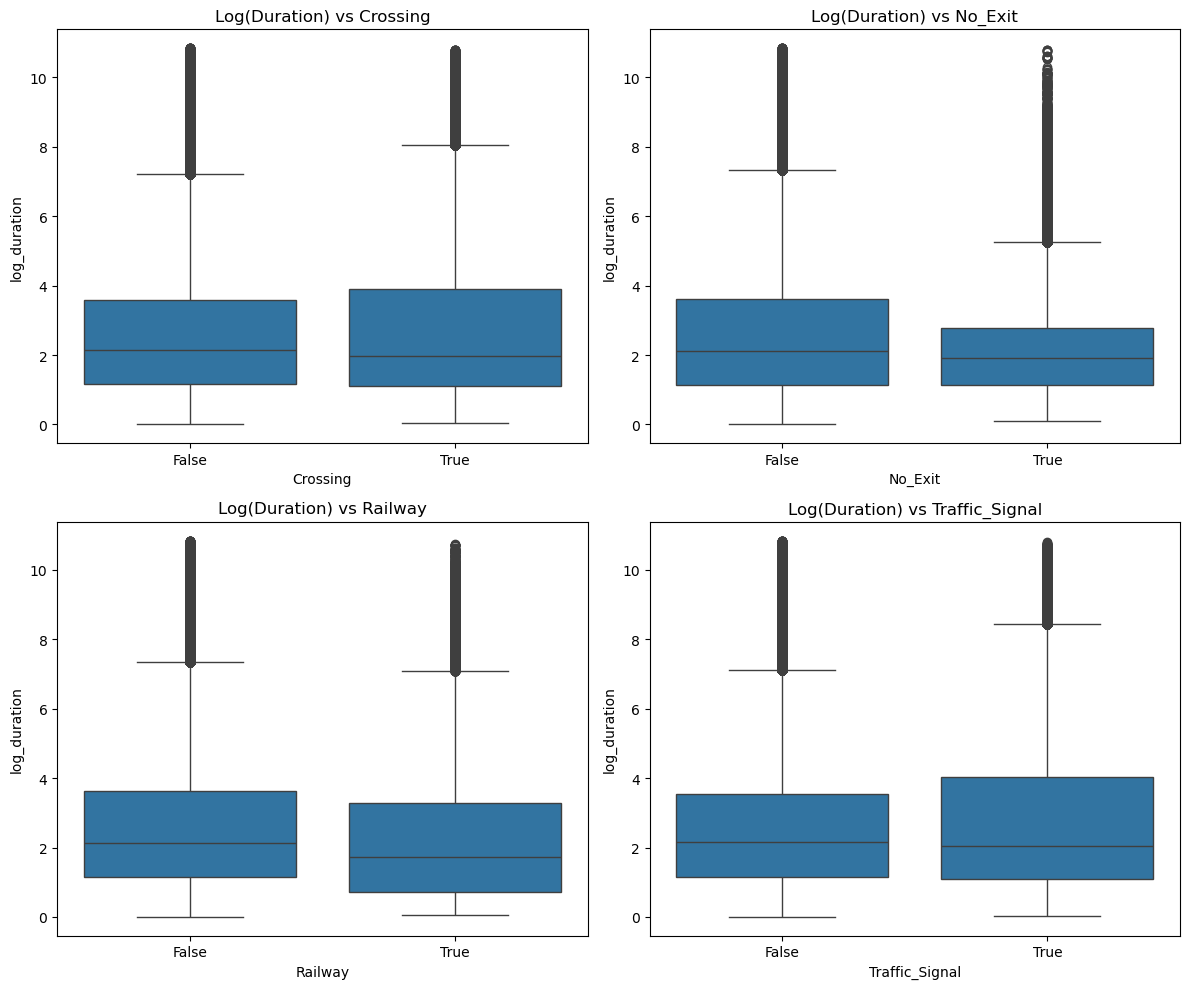

In [103]:
binary_features = ['Crossing', 'No_Exit', 'Railway', 'Traffic_Signal']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(binary_features):
    sns.boxplot(ax=axes[i], x=col, y='log_duration', data=df_cons)
    axes[i].set_title(f'Log(Duration) vs {col}')

plt.tight_layout()
plt.show()

##### Traffic signal and No Exit has very minimal difference, but not that much. Will keep it moving forward to see if found significant or not. However Railway and Crossing does not show significant difference - so dropping them moving forward

##### Check correlation with log of duration

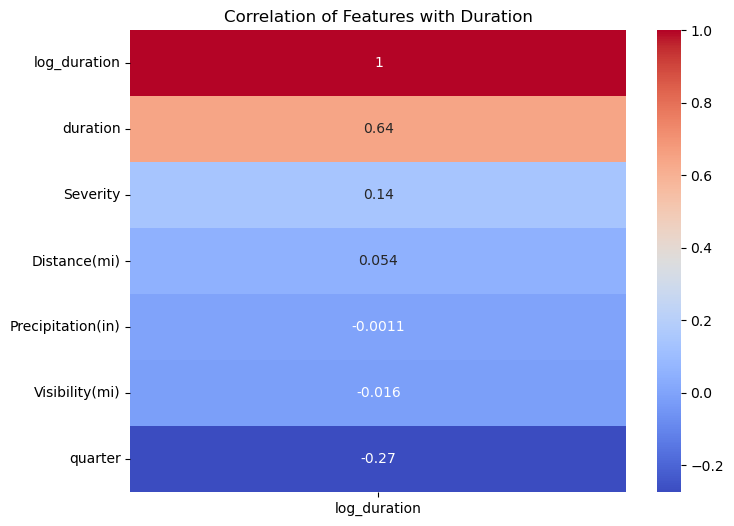

In [105]:
df_corr = df_cons[['log_duration'] + num_features].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr()[['log_duration']].sort_values(by='log_duration', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Duration')
plt.show()

##### Lets move with quater, distance and severity

#### Lets try a model with top features - **Log Linear Regression Model**

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

selected_features = ['road_closure', 'Severity', 'quarter', 'Traffic_Signal', 'No_Exit', 'Crossing', 'Distance(mi)']

In [121]:
df_model = df_cons[selected_features + ['log_duration']].dropna()
# encode categorical variable
df_model = pd.get_dummies(df_model, columns=['road_closure'], drop_first=True)

In [122]:
# final model dataset
X = df_model.drop(columns='log_duration')
y = df_model['log_duration']

#### Trainning, Test data split 80% - 20%

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Train Model

In [124]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Prediction & Accuracy of Model

In [125]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Log-Linear Regression Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

Log-Linear Regression Performance:
MAE: 1.645
RMSE: 2.132
R²: 0.076


#### Only 7.6% variability is explained by the model - performed poorly!

#### Lets try Random Forest Regressor

In [144]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=35, max_depth=35, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [145]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Log-Linear Regression Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

Log-Linear Regression Performance:
MAE: 1.244
RMSE: 1.851
R²: 0.303


##### Random Forest Regressor perform better than the linear regression model. It can explain more than 3o% of the variability

##### Duration Prediction

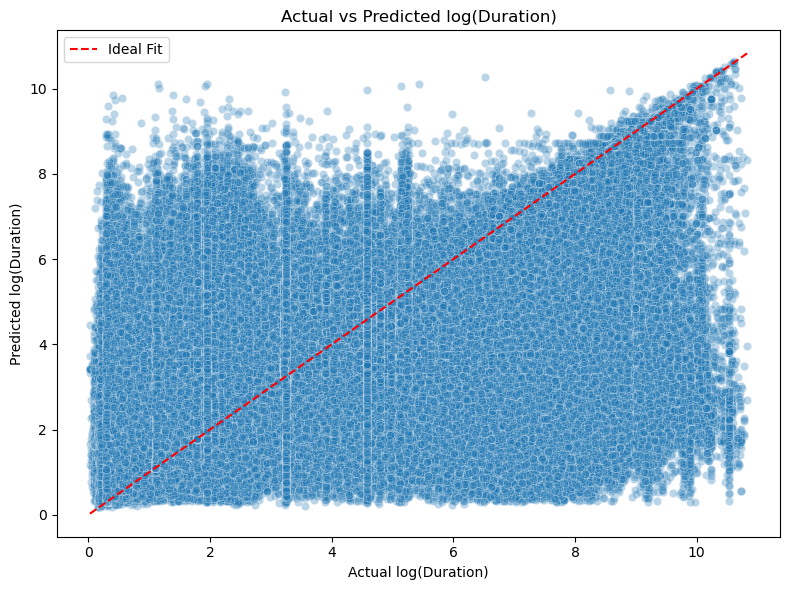

In [146]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel('Actual log(Duration)')
plt.ylabel('Predicted log(Duration)')
plt.title('Actual vs Predicted log(Duration)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.tight_layout()
plt.show()

##### Looks uniformly spreads - no sign of bias - might need interaction variables - also could be better with reducing outliar

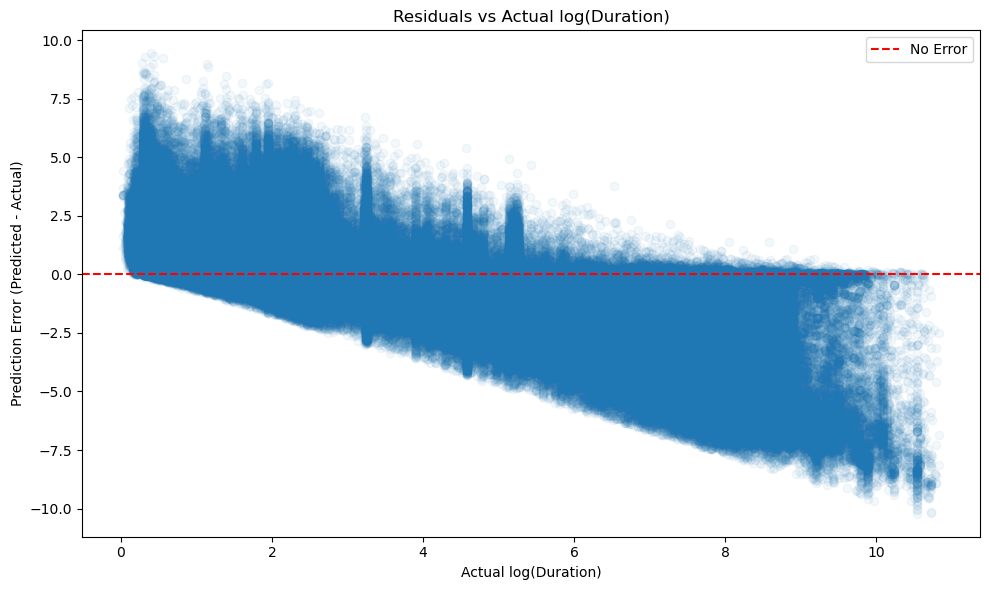

In [147]:
y_residuals = y_pred - y_test

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_residuals, alpha=0.05)
plt.axhline(0, color='red', linestyle='--', label='No Error')
plt.xlabel("Actual log(Duration)")
plt.ylabel("Prediction Error (Predicted - Actual)")
plt.title("Residuals vs Actual log(Duration)")
plt.legend()
plt.tight_layout()
plt.show()

##### Shows heavy tails - indication of removing outliers could improve model

##### Explore Feature Importance

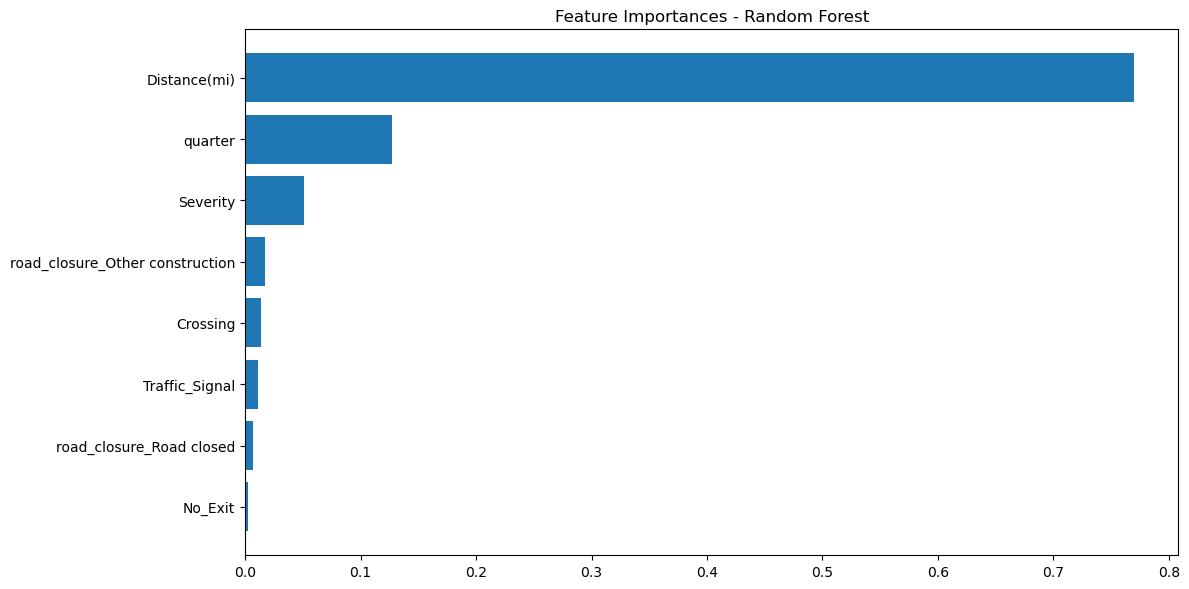

In [148]:
importances = model.feature_importances_
df_feature = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
df_feature = df_feature.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_feature['Feature'], df_feature['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

##### In Final Model distance is very important feature, followed by seasonal effect (Quarter), Severity of construction. Road Closure could be useful in interaction with other key variable.